# **Desarrollo de Modelo IA para prevenir perdidas -> PROPHET STOCK**
# By: S&S Investments

## Creación del entorno (Importación Librerias)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import prophet

/home/santiago/Documentos/S&S_Investments/IA_Explore/EDA_SS_IA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Cargar Dataframe de cada stock hasta el dia actual

### Función para construir los dataframes con indicadores

In [2]:

def ta_sma(source, length, rounded=7) -> float:
    sum_length = sum(source)
    SMA = round(sum_length/length, rounded)
    return SMA

def ta_ema(source: pd.Series, length: int, rounded=7, ):
    alpha = 2 / (length + 1)
    SMA = []
    EMA = []
    aux = 0
    prev_ema = 0
    for close_price in source:
        aux = aux + 1
        if (aux < length):
            SMA.append(close_price)
            EMA.append(None)
            continue
        elif (aux == length):
            prev_ema = ta_sma(SMA, length)
            EMA.append(prev_ema)
            continue
        elif (aux > length):
            close_price = round(close_price, rounded)
            prev_ema = round(
                (alpha * close_price + (1 - alpha) * prev_ema), rounded)
            EMA.append(prev_ema)
    return EMA

def ta_second_ema(source, length, rounded=7):
    alpha = 2 / (length + 1)
    SMA = []
    EMA2 = []
    aux = 0
    prev_ema2 = 0
    for ema_value in source:
        if (ema_value == None):
            EMA2.append(None)
            continue
        elif (ema_value != None):
            aux = aux + 1
            if (aux < length):
                SMA.append(ema_value)
                EMA2.append(None)
                continue
            elif (aux == length):
                prev_ema2 = ta_sma(SMA, length)
                EMA2.append(prev_ema2)
                continue
            elif (aux > length):
                prev_ema2 = round(
                    (alpha * ema_value + (1 - alpha) * prev_ema2), rounded)
                EMA2.append(prev_ema2)
    return EMA2

def dema(df: pd.DataFrame, length: int = 800, rounded=7):
    src = df['Close']
    e1 = ta_ema(src, length)
    e2 = ta_second_ema(e1, length)
    dema = []
    for a, b in zip(e1, e2):
        if a is None or b is None:
            dema.append(None)
        else:
            result = round(2 * a - b, rounded)
            dema.append(result)
    return dema

def update_df(data: pd.DataFrame, test_length: int = 800):
    kline = data.iloc[::-1].reset_index(drop=True)
    _ema = ta_ema(kline['Close'], test_length)
    _dema = dema(kline, test_length)
    kline["EMA"] = _ema
    kline["DEMA800"] = _dema
    FULL_original_order_kline = kline.iloc[::-1].reset_index(drop=True)
    return FULL_original_order_kline

In [3]:
import requests
import pytz
import pandas_ta as ta
from datetime import datetime

def get_historical_data(reg_time:int, symbol:str, interval: str)->pd.DataFrame:
    list_registers = []
    unix_endtime = None
    for i in range(0, 3):
        if i == 0:  # Primer llamado: Historial de mercado con tiempo actual
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(1000)+'&end='+str(reg_time)
            while (True):
                try:
                    data = requests.get(url).json()
                    unix_endtime = data['result']["list"][-1][0]
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except Exception as e:
                    print(
                        f"An error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        if i == 1 and unix_endtime != None:
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(1000)+'&end='+str(unix_endtime)
            while (True):
                try:
                    data = requests.get(url).json()
                    unix_endtime = data['result']["list"][-1][0]
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        if i == 2 and unix_endtime != None:
            url = 'http://api.bybit.com/v5/market/kline?symbol='+symbol + \
                '&interval='+interval+'&limit=' + \
                str(200)+'&end='+str(unix_endtime)
            while (True):
                try:
                    data = requests.get(url).json()
                    break
                except requests.exceptions.ConnectionError as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
                except requests.RequestException as e:
                    print(
                        f"Connection error occurred: {e}, Retrying in 10 seconds...\n")
                    time.sleep(10)
        # Crear proto dataframe y añadir a lista
        df = pd.DataFrame(data['result']["list"], columns=[
                          'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover'])
        df['Time'] = pd.to_numeric(df['Time'])
        df = df.drop_duplicates()
        df['Time'] = df['Time'].apply(
            lambda x: datetime.fromtimestamp(x / 1000, tz=pytz.UTC))
        target_timezone = pytz.timezone('Etc/GMT+5')
        df['Time'] = df['Time'].apply(lambda x: x.astimezone(target_timezone))
        df = df.drop(columns=['Turnover'])
        list_registers.append(df)

    concatenated_df = pd.concat(
        [list_registers[0], list_registers[1], list_registers[2]], axis=0)
    concatenated_df = concatenated_df.reset_index(drop=True)
    float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    concatenated_df[float_columns] = concatenated_df[float_columns].astype(
        float)
    concatenated_df = concatenated_df.drop_duplicates()
    return concatenated_df

def CalculateSupertrend(data: pd.DataFrame):
    mult = 3
    reversed_df = data.iloc[::-1]
    Temp_Trend = ta.supertrend(
        high=reversed_df['High'],
        low=reversed_df['Low'],
        close=reversed_df['Close'],
        period=10,
        multiplier=mult)
    
    ATR = ta.atr(high=reversed_df['High'], low=reversed_df['Low'], close=reversed_df['Close'], length=14)
    ADX = ta.adx(high=reversed_df['High'], low=reversed_df['Low'], close=reversed_df['Close'], length=14)

    Temp_Trend = Temp_Trend.rename(columns={f'SUPERT_7_{mult}.0': 'Supertrend', f'SUPERTd_7_{mult}.0': 'Polaridad',
                                   f'SUPERTl_7_{mult}.0': 'ST_Inferior', f'SUPERTs_7_{mult}.0': 'ST_Superior'})

    df_merge = pd.merge(data, Temp_Trend, left_index=True, right_index=True)
    df_merge = pd.merge(df_merge, ATR, left_index=True, right_index=True)
    df_merge = pd.merge(df_merge, ADX, left_index=True, right_index=True)

    df_merge_ma_final = update_df(df_merge) # Actualizar el dataframe con las medias moviles (EMA , DEMA)
    return df_merge_ma_final

### Crear dataframes

In [45]:
reg_time = datetime.now().timestamp() * 1000
df_XRPUSDT = get_historical_data(reg_time,'XRPUSDT',"30")
df_XRPUSDT = CalculateSupertrend(df_XRPUSDT)
df_ONEUSDT = get_historical_data(reg_time,'ONEUSDT',"30")
df_ONEUSDT = CalculateSupertrend(df_ONEUSDT)
df_DOTUSDT = get_historical_data(reg_time,'DOTUSDT',"30")
df_DOTUSDT = CalculateSupertrend(df_DOTUSDT)
print("Datasets cargados para las historias de las 3 stocks")

Datasets cargados para las historias de las 3 stocks


## Funciones Auxiliares para Modelos Prophet

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
def prepare_dataframe(df: pd.DataFrame, regressors: list)-> pd.DataFrame:
    df = df.rename(columns={'Time': 'ds', 'Close': 'y'})
    df = df.drop(columns=["ST_Superior", "ST_Inferior"])
    df = df.sort_values(by='ds')
    df['ds'] = df['ds'].dt.tz_localize(None)
    df = df.sort_values(by='ds')
    if len(regressors) > 0:
        df = df.dropna(subset=regressors)
    return df

def create_train_test_split(lenght_n: int, df: pd.DataFrame):
    train_df = df.iloc[:-lenght_n]  # Crear dataset de entreamiento con 96 registros menos
    test_df= df.iloc[-lenght_n:] # Crear dataset de validación con 96 registros futuros
    return train_df, test_df

def create_prophet_model_predictions(lenght_n: int, regressors: list, 
                                    train_df: pd.DataFrame, test_df: pd.DataFrame):
    #Crear y establecer estructura del modelo
    model_prof = prophet.Prophet()
    if len(regressors) > 0:
        for col in regressors:
            model_prof.add_regressor(col)
    model_prof.fit(train_df)
    
    #Predecir valores futuros basado en el modelo local
    future = model_prof.make_future_dataframe(periods=96, freq='30min')
    if len(regressors) > 0:
        for col in regressors:
            future[col] = train_df.iloc[-1][col] #Usar el ultimo valor conocido
    forecast = model_prof.predict(future)
    predicted_data = forecast[-n_test:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return pd.merge(test_df, predicted_data, on='ds')

def calculate_metrics_prophet(merged_metrics:pd.DataFrame, image_name: str):
    PATH = f"Resources/Reportes_Prophet/{image_name}"
    mae = mean_absolute_error(merged_metrics['y'], merged_metrics['yhat'])
    mse = mean_squared_error(merged_metrics['y'], merged_metrics['yhat'])
    rmse = np.sqrt(mse)
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    
    #Generar y guardar imagen
    fig = plt.figure(figsize=(12, 6))
    plt.plot(merged_metrics['ds'], merged_metrics['y'], label='Actual Close', color='blue')
    plt.plot(merged_metrics['ds'], merged_metrics['yhat'], label='Predicted Close', color='red')
    plt.fill_between(merged_metrics['ds'], merged_metrics['yhat_lower'], merged_metrics['yhat_upper'], 
                     color='gray', alpha=0.3, label='Confidence Interval')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Actual vs Predicted Close Prices')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    
    # Save the figure to an image file
    plt.savefig(PATH, format='png')
    
    # Show the figure (optional)
    plt.show()
    
    return fig
    

## Modelo Prophet para XRPUSDT

In [20]:
df_XRPUSDT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype                    
---  ------       --------------  -----                    
 0   Time         2198 non-null   datetime64[ns, Etc/GMT+5]
 1   Open         2198 non-null   float64                  
 2   High         2198 non-null   float64                  
 3   Low          2198 non-null   float64                  
 4   Close        2198 non-null   float64                  
 5   Volume       2198 non-null   float64                  
 6   Supertrend   2192 non-null   float64                  
 7   Polaridad    2198 non-null   int64                    
 8   ST_Inferior  1269 non-null   float64                  
 9   ST_Superior  922 non-null    float64                  
 10  ATRr_14      2184 non-null   float64                  
 11  ADX_14       2171 non-null   float64                  
 12  DMP_14       2184 non-null   float64            

### Separación y preparación de los datos historicos para adquirir metricas

In [27]:
# Ajustar dataset a estructura de entrenamiento
regressors = []
n_test = 96 #96 representa 2 dias en registros de 30 min
clean_XRPUSDT = prepare_dataframe(df_XRPUSDT, regressors)
train_XRP, test_XRP = create_train_test_split(n_test, clean_XRPUSDT)
print(f'Training Data: {train_XRP.shape}')
print(f'Test Data: {test_XRP.shape}')

Training Data: (2102, 14)
Test Data: (96, 14)


### Entrenamiento del modelo Prophet

In [28]:
df_forecast = create_prophet_model_predictions(n_test,regressors, train_XRP, test_XRP)
df_forecast

09:56:18 - cmdstanpy - INFO - Chain [1] start processing
09:56:23 - cmdstanpy - INFO - Chain [1] done processing


,ds,Open,High,Low,y,Volume,Supertrend,Polaridad,ATRr_14,ADX_14,DMP_14,DMN_14,EMA,DEMA800,yhat,yhat_lower,yhat_upper
0,2024-10-19 10:00:00,0.5454,0.5455,0.5447,0.5450,1287815.0,0.548092,-1,0.001524,21.522951,10.714267,15.634755,0.547136,0.538111,0.551875,0.544281,0.560192
1,2024-10-19 10:30:00,0.5450,0.5452,0.5439,0.5444,2460206.0,0.548092,-1,0.001508,22.091464,10.054459,18.461605,0.547129,0.538120,0.552089,0.544249,0.559523
2,2024-10-19 11:00:00,0.5444,0.5444,0.5433,0.5436,2127043.0,0.547900,-1,0.001479,23.107627,9.520220,20.378906,0.547120,0.538125,0.552360,0.544646,0.559645
3,2024-10-19 11:30:00,0.5436,0.5442,0.5398,0.5409,9494761.0,0.547357,-1,0.001687,25.772789,7.747023,31.399022,0.547105,0.538117,0.552681,0.544742,0.560009
4,2024-10-19 12:00:00,0.5409,0.5424,0.5407,0.5416,3267951.0,0.546870,-1,0.001688,28.247582,7.189825,29.140676,0.547091,0.538112,0.553032,0.545588,0.560326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-10-21 07:30:00,0.5523,0.5524,0.5495,0.5510,9371541.0,0.546833,1,0.003371,32.328451,25.287084,18.783605,0.546731,0.539230,0.553655,0.536214,0.570906
92,2024-10-21 08:00:00,0.5510,0.5520,0.5462,0.5494,22308306.0,0.546833,1,0.003545,30.161411,22.331501,23.238290,0.546738,0.539262,0.553806,0.537774,0.571854
93,2024-10-21 08:30:00,0.5494,0.5495,0.5421,0.5441,23246569.0,0.559389,-1,0.003820,29.292799,19.241419,27.689357,0.546732,0.539268,0.553948,0.536539,0.571594
94,2024-10-21 09:00:00,0.5441,0.5464,0.5435,0.5454,9028872.0,0.557841,-1,0.003754,28.486231,18.179746,26.161557,0.546728,0.539280,0.554095,0.536080,0.573242


### Calcular metricas del modelo

MAE: 0.008231757909152362
MSE: 8.40039578615015e-05
RMSE: 0.00916536730641503


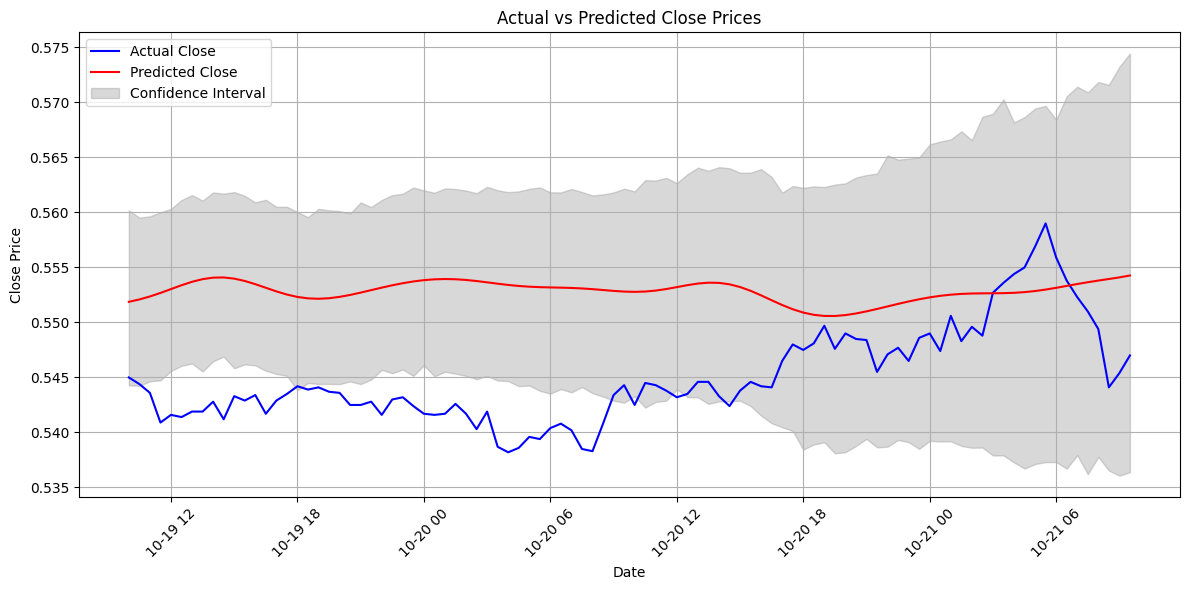

In [29]:
file_name = "XRPUSDT_Prophet_NR.png"
plot = calculate_metrics_prophet(df_forecast, file_name)

## Modelo Prophet para ONEUSDT

In [30]:
df_ONEUSDT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype                    
---  ------       --------------  -----                    
 0   Time         2198 non-null   datetime64[ns, Etc/GMT+5]
 1   Open         2198 non-null   float64                  
 2   High         2198 non-null   float64                  
 3   Low          2198 non-null   float64                  
 4   Close        2198 non-null   float64                  
 5   Volume       2198 non-null   float64                  
 6   Supertrend   2192 non-null   float64                  
 7   Polaridad    2198 non-null   int64                    
 8   ST_Inferior  1227 non-null   float64                  
 9   ST_Superior  964 non-null    float64                  
 10  ATRr_14      2184 non-null   float64                  
 11  ADX_14       2171 non-null   float64                  
 12  DMP_14       2184 non-null   float64            

In [37]:
# Ajustar dataset a estructura de entrenamiento
regressors = ["ADX_14", "ATRr_14"]
n_test = 96 #96 representa 2 dias en registros de 30 min
clean_ONEUSDT = prepare_dataframe(df_ONEUSDT, regressors)
train_ONE, test_ONE = create_train_test_split(n_test, clean_ONEUSDT)
print(f'Training Data: {train_ONE.shape}')
print(f'Test Data: {test_ONE.shape}')

Training Data: (2075, 14)
Test Data: (96, 14)


In [38]:
df_forecast = create_prophet_model_predictions(n_test,regressors, train_ONE, test_ONE)
df_forecast

10:07:09 - cmdstanpy - INFO - Chain [1] start processing
10:07:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,Open,High,Low,y,Volume,Supertrend,Polaridad,ATRr_14,ADX_14,DMP_14,DMN_14,EMA,DEMA800,yhat,yhat_lower,yhat_upper
0,2024-10-19 10:00:00,0.01411,0.01412,0.01402,0.01406,910211.0,0.014304,-1,0.000099,27.656579,18.467652,32.732101,0.013283,0.013587,0.014330,0.014067,0.014587
1,2024-10-19 10:30:00,0.01406,0.01406,0.01399,0.01401,920893.0,0.014298,-1,0.000097,27.894686,17.518511,33.252476,0.013284,0.013590,0.014336,0.014065,0.014611
2,2024-10-19 11:00:00,0.01401,0.01403,0.01396,0.01399,3113385.0,0.014259,-1,0.000095,28.335806,16.599744,33.756197,0.013286,0.013593,0.014343,0.014062,0.014604
3,2024-10-19 11:30:00,0.01399,0.01402,0.01388,0.01388,4494790.0,0.014236,-1,0.000099,29.280482,14.914958,36.129819,0.013288,0.013595,0.014350,0.014075,0.014609
4,2024-10-19 12:00:00,0.01388,0.01395,0.01387,0.01393,867479.0,0.014190,-1,0.000097,30.220564,14.038159,34.740703,0.013289,0.013597,0.014355,0.014085,0.014615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-10-21 07:30:00,0.01466,0.01468,0.01456,0.01464,1895055.0,0.014989,-1,0.000127,30.137062,10.797972,25.919544,0.013544,0.014022,0.014922,0.014372,0.015398
92,2024-10-21 08:00:00,0.01464,0.01467,0.01441,0.01459,12920581.0,0.014969,-1,0.000137,31.757608,9.332331,30.232157,0.013546,0.014026,0.014926,0.014373,0.015443
93,2024-10-21 08:30:00,0.01459,0.01459,0.01433,0.01442,6162286.0,0.014939,-1,0.000146,33.606361,8.142159,30.300651,0.013548,0.014030,0.014932,0.014403,0.015377
94,2024-10-21 09:00:00,0.01442,0.01457,0.01438,0.01453,4023150.0,0.014939,-1,0.000149,35.323060,7.399504,27.536896,0.013551,0.014033,0.014938,0.014420,0.015431


MAE: 0.00027492300415733295
MSE: 9.889082346328639e-08
RMSE: 0.0003144691136873165


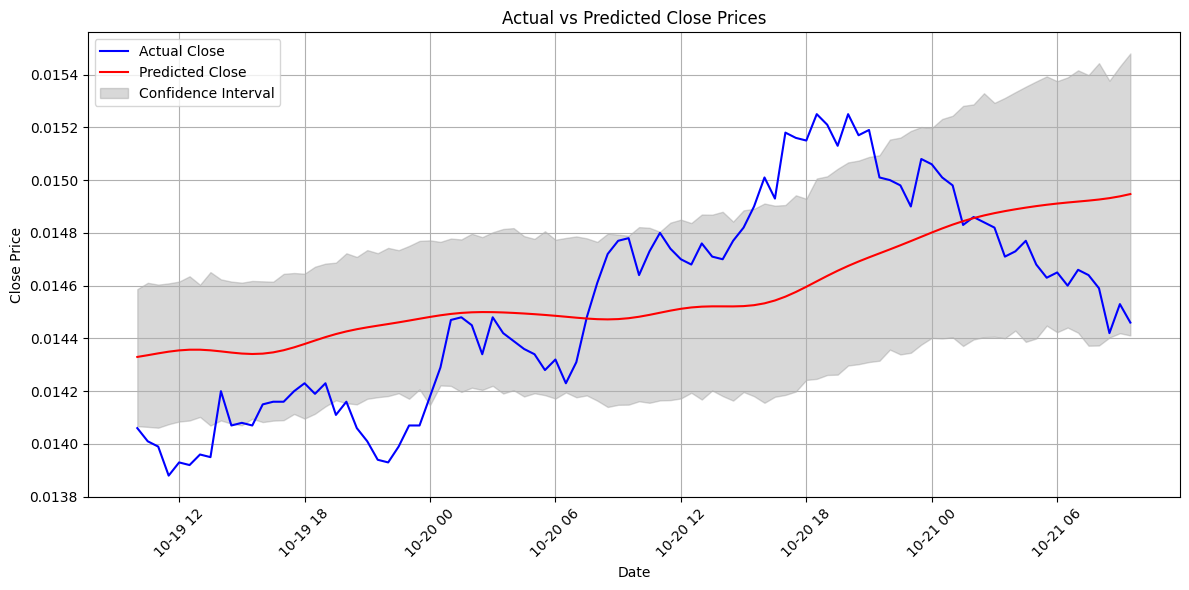

In [39]:
file_name = "ONEUSDT_Prophet_R-ADX14_ATR14.png"
plot = calculate_metrics_prophet(df_forecast, file_name)

## Modelo Prophet para DOTUSDT

In [46]:
df_DOTUSDT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype                    
---  ------       --------------  -----                    
 0   Time         2198 non-null   datetime64[ns, Etc/GMT+5]
 1   Open         2198 non-null   float64                  
 2   High         2198 non-null   float64                  
 3   Low          2198 non-null   float64                  
 4   Close        2198 non-null   float64                  
 5   Volume       2198 non-null   float64                  
 6   Supertrend   2192 non-null   float64                  
 7   Polaridad    2198 non-null   int64                    
 8   ST_Inferior  1150 non-null   float64                  
 9   ST_Superior  1041 non-null   float64                  
 10  ATRr_14      2184 non-null   float64                  
 11  ADX_14       2171 non-null   float64                  
 12  DMP_14       2184 non-null   float64            

In [53]:
# Ajustar dataset a estructura de entrenamiento
regressors = ["Volume", "High", "Low"]
n_test = 96 #96 representa 2 dias en registros de 30 min
clean_DOTUSDT = prepare_dataframe(df_DOTUSDT, regressors)
train_DOT, test_DOT = create_train_test_split(n_test, clean_DOTUSDT)
print(f'Training Data: {train_DOT.shape}')
print(f'Test Data: {test_DOT.shape}')

Training Data: (2102, 14)
Test Data: (96, 14)


In [54]:
df_forecast = create_prophet_model_predictions(n_test,regressors, train_DOT, test_DOT)
df_forecast

10:58:25 - cmdstanpy - INFO - Chain [1] start processing
10:58:26 - cmdstanpy - INFO - Chain [1] done processing


,ds,Open,High,Low,y,Volume,Supertrend,Polaridad,ATRr_14,ADX_14,DMP_14,DMN_14,EMA,DEMA800,yhat,yhat_lower,yhat_upper
0,2024-10-19 11:00:00,4.403,4.408,4.382,4.406,107312.4,4.406961,-1,0.023243,18.096980,26.206136,19.352069,4.267608,4.245980,4.397345,4.385009,4.410116
1,2024-10-19 11:30:00,4.406,4.429,4.397,4.399,240746.4,4.406961,-1,0.023869,18.682146,29.980988,17.498865,4.267936,4.246689,4.397264,4.384498,4.409838
2,2024-10-19 12:00:00,4.399,4.425,4.399,4.420,155778.3,4.338506,1,0.024021,19.225514,27.663039,16.145959,4.268316,4.247501,4.397112,4.384636,4.410133
3,2024-10-19 12:30:00,4.420,4.423,4.394,4.402,95773.6,4.338506,1,0.024376,19.411999,25.312329,16.239044,4.268650,4.248219,4.396898,4.383967,4.408854
4,2024-10-19 13:00:00,4.402,4.428,4.400,4.414,88730.5,4.338506,1,0.024635,19.789414,24.707084,14.920688,4.269013,4.248995,4.396651,4.384658,4.409981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2024-10-21 08:30:00,4.429,4.429,4.355,4.377,480892.3,4.501383,-1,0.031316,31.011973,8.721847,39.998047,4.309836,4.330743,4.397797,4.385218,4.410781
92,2024-10-21 09:00:00,4.377,4.405,4.373,4.394,255150.0,4.496471,-1,0.031365,33.382258,8.086235,37.083158,4.310046,4.331110,4.397846,4.384608,4.410753
93,2024-10-21 09:30:00,4.394,4.397,4.372,4.394,106300.5,4.487332,-1,0.030910,35.597047,7.619081,35.171892,4.310256,4.331476,4.397906,4.385192,4.409861
94,2024-10-21 10:00:00,4.394,4.394,4.357,4.364,123161.7,4.479499,-1,0.031345,37.857729,6.976675,35.624551,4.310390,4.331691,4.397965,4.384815,4.410385


MAE: 0.07531626940374164
MSE: 0.009749258264884276
RMSE: 0.09873833229746326


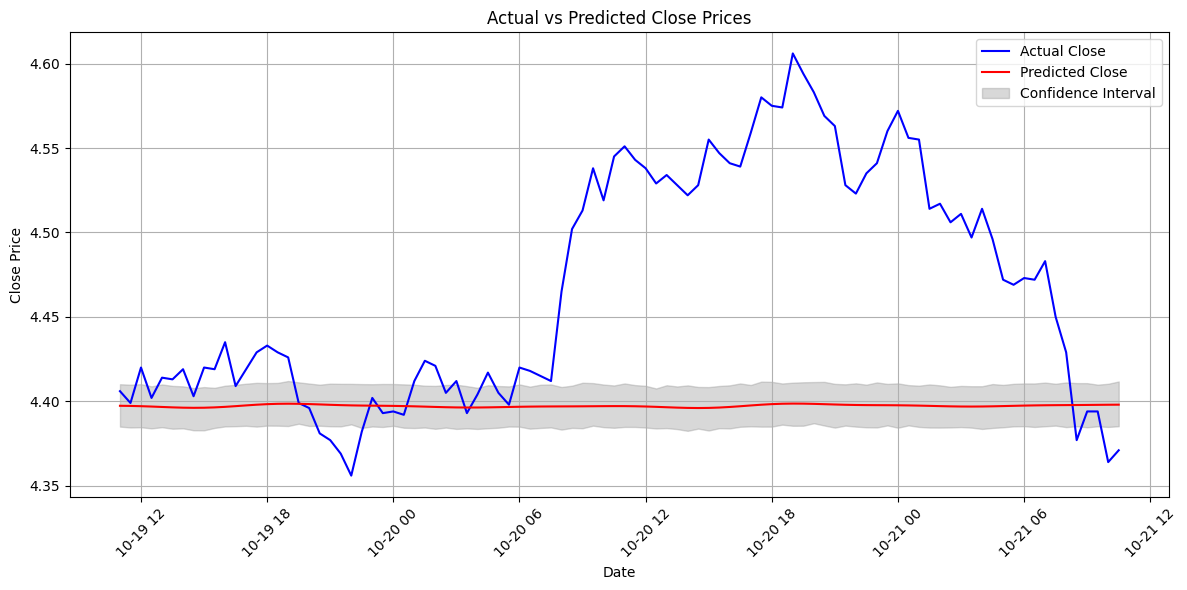

In [55]:
file_name = "DOTUSDT_Prophet_R-V_H_L.png"
plot = calculate_metrics_prophet(df_forecast, file_name)

## Modelo Prophet implementado a ordenes

El objetivo es usar el archivo de ordenes simuladas, crear las correspondientes ventanas de tiempo y determinar si el modelo es capaz de reducir las perdidas generales de la estrategia

### Zona de analitica Inicial

In [60]:
df_simulacion = pd.read_csv('Resources/Activos/history_SP3_DEMA800_30M_3Y.csv')
df_simulacion = df_simulacion[df_simulacion['Time'] >= '2022-01-01']
df_simulacion.head(5)

,Time,Symbol,Open,High,Low,Close,Volume,Supertrend,Polaridad,DEMA800,Half-Order,Profit,Stoploss-Reached,Exit-Price,ATR,ADX,P&L
44,2022-01-01 23:30:00-05:00,XRPUSDT,0.8450,0.8460,0.8375,0.8394,4414373.0,0.853392,Sell,0.858293,False,False,True,0.853392,0.003937,19.388368,-0.2268
45,2022-01-02 22:30:00-05:00,XRPUSDT,0.8499,0.8500,0.8440,0.8459,1757438.0,0.859168,Sell,0.854829,True,True,False,0.842400,0.004050,21.994251,0.1421
46,2022-01-04 13:00:00-05:00,XRPUSDT,0.8292,0.8310,0.8265,0.8274,3164956.0,0.843072,Sell,0.845364,True,True,False,0.773400,0.004677,17.204269,0.5859
47,2022-01-06 21:30:00-05:00,XRPUSDT,0.7694,0.7697,0.7631,0.7636,1609111.0,0.782929,Sell,0.816084,True,False,False,0.763600,0.006254,24.509269,0.1330
48,2022-01-08 10:00:00-05:00,XRPUSDT,0.7604,0.7618,0.7500,0.7554,6189295.0,0.772334,Sell,0.794400,True,False,False,0.755400,0.005361,20.871693,0.1421


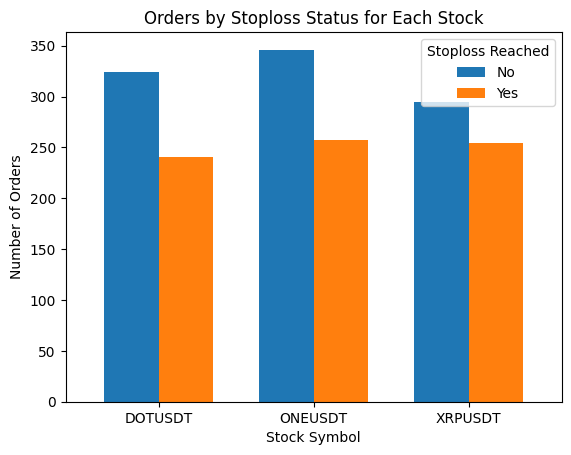

In [61]:
# Count the occurrences of stoploss_reached per stock symbol
grouped = df_simulacion.groupby(['Symbol', 'Stoploss-Reached']).size().unstack(fill_value=0)

# Plot
grouped.plot(kind='bar', width=0.7)
plt.title("Orders by Stoploss Status for Each Stock")
plt.xlabel("Stock Symbol")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.legend(title='Stoploss Reached', labels=['No', 'Yes'])

plt.show()

### Zona de Simulación

In [75]:
res_aprobado = []
res_desaprobado = []
for i in range(len(df_simulacion)):
    print(f"Procesando registro/orden {i}...")
    reg_time = int(datetime.fromisoformat(df_simulacion.iloc[i]["Time"]).timestamp() * 1000)
    df_temp = get_historical_data(reg_time,df_simulacion.iloc[i]['Symbol'],"30")
    df_temp = CalculateSupertrend(df_temp)
    # Ajustar dataset a estructura de entrenamiento
    regressors = ["ADX_14", "ATRr_14"]
    clean_temp = prepare_dataframe(df_temp, regressors)
    #clean_temp = clean_temp.dropna(subset=["ADX_14", "ATRr_14"])
    #Entrenar modelo
    model_prof = prophet.Prophet()
    for col in regressors:
        model_prof.add_regressor(col)
    model_prof.fit(clean_temp)
    #Predecir valores futuros basado en el modelo local
    future = model_prof.make_future_dataframe(periods=96, freq='30min')
    for col in regressors:
        future[col] = clean_temp.iloc[-1][col] #Usar el ultimo valor conocido
    forecast = model_prof.predict(future)
    predicted_data = forecast[-96:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    #Encontrar tendencia de crecimiento o decrecimiento
    tendencia = predicted_data['yhat'].iloc[-1] - predicted_data['yhat'].iloc[0]
    if df_simulacion.iloc[i]["Polaridad"] == "Buy":
        if tendencia > 0:
            res_aprobado.append(df_simulacion.iloc[i])
        else:
            res_desaprobado.append(df_simulacion.iloc[i])
    else:
        if tendencia < 0:
            res_aprobado.append(df_simulacion.iloc[i])
        else:
            res_desaprobado.append(df_simulacion.iloc[i])

Procesando registro/orden 659...


17:22:22 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 660...


17:22:28 - cmdstanpy - INFO - Chain [1] start processing
17:22:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 661...


17:22:36 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 662...


17:22:42 - cmdstanpy - INFO - Chain [1] start processing
17:22:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 663...


17:22:52 - cmdstanpy - INFO - Chain [1] start processing
17:22:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 664...


17:22:59 - cmdstanpy - INFO - Chain [1] start processing
17:23:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 665...


17:23:08 - cmdstanpy - INFO - Chain [1] start processing
17:23:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 666...


17:23:15 - cmdstanpy - INFO - Chain [1] start processing
17:23:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 667...


17:23:23 - cmdstanpy - INFO - Chain [1] start processing
17:23:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 668...


17:23:32 - cmdstanpy - INFO - Chain [1] start processing
17:23:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 669...


17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 670...


17:23:45 - cmdstanpy - INFO - Chain [1] start processing
17:23:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 671...


17:23:51 - cmdstanpy - INFO - Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 672...


17:23:57 - cmdstanpy - INFO - Chain [1] start processing
17:23:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 673...


17:24:05 - cmdstanpy - INFO - Chain [1] start processing
17:24:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 674...


17:24:11 - cmdstanpy - INFO - Chain [1] start processing
17:24:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 675...


17:24:17 - cmdstanpy - INFO - Chain [1] start processing
17:24:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 676...


17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 677...


17:24:29 - cmdstanpy - INFO - Chain [1] start processing
17:24:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 678...


17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 679...


17:24:44 - cmdstanpy - INFO - Chain [1] start processing
17:24:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 680...


17:24:52 - cmdstanpy - INFO - Chain [1] start processing
17:24:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 681...


17:24:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 682...


17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 683...


17:25:11 - cmdstanpy - INFO - Chain [1] start processing
17:25:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 684...


17:25:17 - cmdstanpy - INFO - Chain [1] start processing
17:25:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 685...


17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 686...


17:25:30 - cmdstanpy - INFO - Chain [1] start processing
17:25:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 687...


17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 688...


17:25:45 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 689...


17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 690...


17:25:57 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 691...


17:26:05 - cmdstanpy - INFO - Chain [1] start processing
17:26:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 692...


17:26:11 - cmdstanpy - INFO - Chain [1] start processing
17:26:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 693...


17:26:18 - cmdstanpy - INFO - Chain [1] start processing
17:26:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 694...


17:26:24 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 695...


17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 696...


17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 697...


17:26:46 - cmdstanpy - INFO - Chain [1] start processing
17:26:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 698...


17:26:53 - cmdstanpy - INFO - Chain [1] start processing
17:26:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 699...


17:26:59 - cmdstanpy - INFO - Chain [1] start processing
17:27:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 700...


17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 701...


17:27:11 - cmdstanpy - INFO - Chain [1] start processing
17:27:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 702...


17:27:19 - cmdstanpy - INFO - Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 703...


17:27:26 - cmdstanpy - INFO - Chain [1] start processing
17:27:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 704...


17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 705...


17:27:39 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 706...


17:27:47 - cmdstanpy - INFO - Chain [1] start processing
17:27:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 707...


17:27:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 708...


17:28:01 - cmdstanpy - INFO - Chain [1] start processing
17:28:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 709...


17:28:07 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 710...


17:28:15 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 711...


17:28:21 - cmdstanpy - INFO - Chain [1] start processing
17:28:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 712...


17:28:28 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 713...


17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 714...


17:28:41 - cmdstanpy - INFO - Chain [1] start processing
17:28:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 715...


17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 716...


17:28:54 - cmdstanpy - INFO - Chain [1] start processing
17:28:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 717...


17:29:02 - cmdstanpy - INFO - Chain [1] start processing
17:29:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 718...


17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 719...


17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 720...


17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 721...


17:29:27 - cmdstanpy - INFO - Chain [1] start processing
17:29:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 722...


17:29:34 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 723...


17:29:39 - cmdstanpy - INFO - Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 724...


17:29:45 - cmdstanpy - INFO - Chain [1] start processing
17:29:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 725...


17:29:52 - cmdstanpy - INFO - Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 726...


17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 727...


17:30:06 - cmdstanpy - INFO - Chain [1] start processing
17:30:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 728...


17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 729...


17:30:19 - cmdstanpy - INFO - Chain [1] start processing
17:30:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 730...


17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 731...


17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 732...


17:30:38 - cmdstanpy - INFO - Chain [1] start processing
17:30:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 733...


17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 734...


17:30:52 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 735...


17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:31:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 736...


17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 737...


17:31:13 - cmdstanpy - INFO - Chain [1] start processing
17:31:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 738...


17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 739...


17:31:26 - cmdstanpy - INFO - Chain [1] start processing
17:31:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 740...


17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 741...


17:31:42 - cmdstanpy - INFO - Chain [1] start processing
17:31:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 742...


17:31:53 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 743...


17:32:01 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 744...


17:32:09 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 745...


17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 746...


17:32:23 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 747...


17:32:31 - cmdstanpy - INFO - Chain [1] start processing
17:32:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 748...


17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 749...


17:32:45 - cmdstanpy - INFO - Chain [1] start processing
17:32:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 750...


17:32:52 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 751...


17:32:58 - cmdstanpy - INFO - Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 752...


17:33:05 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 753...


17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 754...


17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 755...


17:33:28 - cmdstanpy - INFO - Chain [1] start processing
17:33:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 756...


17:33:34 - cmdstanpy - INFO - Chain [1] start processing
17:33:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 757...


17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 758...


17:33:46 - cmdstanpy - INFO - Chain [1] start processing
17:33:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 759...


17:33:54 - cmdstanpy - INFO - Chain [1] start processing
17:33:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 760...


17:34:00 - cmdstanpy - INFO - Chain [1] start processing
17:34:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 761...


17:34:06 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 762...


17:34:13 - cmdstanpy - INFO - Chain [1] start processing
17:34:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 763...


17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 764...


17:34:27 - cmdstanpy - INFO - Chain [1] start processing
17:34:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 765...


17:34:33 - cmdstanpy - INFO - Chain [1] start processing
17:34:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 766...


17:34:39 - cmdstanpy - INFO - Chain [1] start processing
17:34:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 767...


17:34:46 - cmdstanpy - INFO - Chain [1] start processing
17:34:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 768...


17:34:53 - cmdstanpy - INFO - Chain [1] start processing
17:34:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 769...


17:34:59 - cmdstanpy - INFO - Chain [1] start processing
17:35:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 770...


17:35:06 - cmdstanpy - INFO - Chain [1] start processing
17:35:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 771...


17:35:12 - cmdstanpy - INFO - Chain [1] start processing
17:35:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 772...


17:35:20 - cmdstanpy - INFO - Chain [1] start processing
17:35:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 773...


17:35:27 - cmdstanpy - INFO - Chain [1] start processing
17:35:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 774...


17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 775...


17:35:39 - cmdstanpy - INFO - Chain [1] start processing
17:35:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 776...


17:35:45 - cmdstanpy - INFO - Chain [1] start processing
17:35:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 777...


17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 778...


17:35:58 - cmdstanpy - INFO - Chain [1] start processing
17:36:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 779...


17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 780...


17:36:10 - cmdstanpy - INFO - Chain [1] start processing
17:36:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 781...


17:36:16 - cmdstanpy - INFO - Chain [1] start processing
17:36:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 782...


17:36:22 - cmdstanpy - INFO - Chain [1] start processing
17:36:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 783...


17:36:30 - cmdstanpy - INFO - Chain [1] start processing
17:36:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 784...


17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 785...


17:36:45 - cmdstanpy - INFO - Chain [1] start processing
17:36:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 786...


17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 787...


17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:37:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 788...


17:37:05 - cmdstanpy - INFO - Chain [1] start processing
17:37:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 789...


17:37:10 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 790...


17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 791...


17:37:24 - cmdstanpy - INFO - Chain [1] start processing
17:37:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 792...


17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 793...


17:37:37 - cmdstanpy - INFO - Chain [1] start processing
17:37:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 794...


17:37:43 - cmdstanpy - INFO - Chain [1] start processing
17:37:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 795...


17:37:51 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 796...


17:37:57 - cmdstanpy - INFO - Chain [1] start processing
17:37:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 797...


17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 798...


17:38:09 - cmdstanpy - INFO - Chain [1] start processing
17:38:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 799...


17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 800...


17:38:22 - cmdstanpy - INFO - Chain [1] start processing
17:38:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 801...


17:38:27 - cmdstanpy - INFO - Chain [1] start processing
17:38:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 802...


17:38:33 - cmdstanpy - INFO - Chain [1] start processing
17:38:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 803...


17:38:39 - cmdstanpy - INFO - Chain [1] start processing
17:38:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 804...


17:38:46 - cmdstanpy - INFO - Chain [1] start processing
17:38:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 805...


17:38:52 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 806...


17:38:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 807...


17:39:04 - cmdstanpy - INFO - Chain [1] start processing
17:39:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 808...


17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 809...


17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 810...


17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 811...


17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 812...


17:39:35 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 813...


17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 814...


17:39:48 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 815...


17:39:54 - cmdstanpy - INFO - Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 816...


17:40:01 - cmdstanpy - INFO - Chain [1] start processing
17:40:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 817...


17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 818...


17:40:13 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 819...


17:40:19 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 820...


17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 821...


17:40:33 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 822...


17:40:41 - cmdstanpy - INFO - Chain [1] start processing
17:40:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 823...


17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 824...


17:40:55 - cmdstanpy - INFO - Chain [1] start processing
17:40:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 825...


17:41:03 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 826...


17:41:12 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 827...


17:41:18 - cmdstanpy - INFO - Chain [1] start processing
17:41:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 828...


17:41:25 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 829...


17:41:31 - cmdstanpy - INFO - Chain [1] start processing
17:41:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 830...


17:41:37 - cmdstanpy - INFO - Chain [1] start processing
17:41:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 831...


17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 832...


17:41:51 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 833...


17:41:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 834...


17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 835...


17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 836...


17:42:20 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 837...


17:42:28 - cmdstanpy - INFO - Chain [1] start processing
17:42:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 838...


17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 839...


17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 840...


17:42:48 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 841...


17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 842...


17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 843...


17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:43:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 844...


17:43:14 - cmdstanpy - INFO - Chain [1] start processing
17:43:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 845...


17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 846...


17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 847...


17:43:37 - cmdstanpy - INFO - Chain [1] start processing
17:43:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 848...


17:43:43 - cmdstanpy - INFO - Chain [1] start processing
17:43:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 849...


17:43:50 - cmdstanpy - INFO - Chain [1] start processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 850...


17:43:57 - cmdstanpy - INFO - Chain [1] start processing
17:43:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 851...


17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 852...


17:44:10 - cmdstanpy - INFO - Chain [1] start processing
17:44:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 853...


17:44:17 - cmdstanpy - INFO - Chain [1] start processing
17:44:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 854...


17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 855...


17:44:30 - cmdstanpy - INFO - Chain [1] start processing
17:44:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 856...


17:44:36 - cmdstanpy - INFO - Chain [1] start processing
17:44:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 857...


17:44:42 - cmdstanpy - INFO - Chain [1] start processing
17:44:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 858...


17:44:50 - cmdstanpy - INFO - Chain [1] start processing
17:44:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 859...


17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 860...


17:45:04 - cmdstanpy - INFO - Chain [1] start processing
17:45:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 861...


17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 862...


17:45:17 - cmdstanpy - INFO - Chain [1] start processing
17:45:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 863...


17:45:26 - cmdstanpy - INFO - Chain [1] start processing
17:45:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 864...


17:45:33 - cmdstanpy - INFO - Chain [1] start processing
17:45:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 865...


17:45:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 866...


17:45:47 - cmdstanpy - INFO - Chain [1] start processing
17:45:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 867...


17:45:54 - cmdstanpy - INFO - Chain [1] start processing
17:45:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 868...


17:46:00 - cmdstanpy - INFO - Chain [1] start processing
17:46:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 869...


17:46:06 - cmdstanpy - INFO - Chain [1] start processing
17:46:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 870...


17:46:12 - cmdstanpy - INFO - Chain [1] start processing
17:46:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 871...


17:46:20 - cmdstanpy - INFO - Chain [1] start processing
17:46:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 872...


17:46:26 - cmdstanpy - INFO - Chain [1] start processing
17:46:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 873...


17:46:32 - cmdstanpy - INFO - Chain [1] start processing
17:46:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 874...


17:46:38 - cmdstanpy - INFO - Chain [1] start processing
17:46:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 875...


17:46:43 - cmdstanpy - INFO - Chain [1] start processing
17:46:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 876...


17:46:49 - cmdstanpy - INFO - Chain [1] start processing
17:46:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 877...


17:46:54 - cmdstanpy - INFO - Chain [1] start processing
17:46:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 878...


17:46:59 - cmdstanpy - INFO - Chain [1] start processing
17:47:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 879...


17:47:04 - cmdstanpy - INFO - Chain [1] start processing
17:47:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 880...


17:47:09 - cmdstanpy - INFO - Chain [1] start processing
17:47:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 881...


17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 882...


17:47:18 - cmdstanpy - INFO - Chain [1] start processing
17:47:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 883...


17:47:26 - cmdstanpy - INFO - Chain [1] start processing
17:47:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 884...


17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:47:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 885...


17:47:37 - cmdstanpy - INFO - Chain [1] start processing
17:47:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 886...


17:47:44 - cmdstanpy - INFO - Chain [1] start processing
17:47:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 887...


17:47:50 - cmdstanpy - INFO - Chain [1] start processing
17:47:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 888...


17:47:56 - cmdstanpy - INFO - Chain [1] start processing
17:47:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 889...


17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 890...


17:48:06 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 891...


17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 892...


17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 893...


17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 894...


17:48:31 - cmdstanpy - INFO - Chain [1] start processing
17:48:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 895...


17:48:38 - cmdstanpy - INFO - Chain [1] start processing
17:48:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 896...


17:48:45 - cmdstanpy - INFO - Chain [1] start processing
17:48:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 897...


17:48:51 - cmdstanpy - INFO - Chain [1] start processing
17:48:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 898...


17:48:56 - cmdstanpy - INFO - Chain [1] start processing
17:48:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 899...


17:49:03 - cmdstanpy - INFO - Chain [1] start processing
17:49:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 900...


17:49:10 - cmdstanpy - INFO - Chain [1] start processing
17:49:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 901...


17:49:16 - cmdstanpy - INFO - Chain [1] start processing
17:49:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 902...


17:49:21 - cmdstanpy - INFO - Chain [1] start processing
17:49:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 903...


17:49:27 - cmdstanpy - INFO - Chain [1] start processing
17:49:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 904...


17:49:35 - cmdstanpy - INFO - Chain [1] start processing
17:49:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 905...


17:49:42 - cmdstanpy - INFO - Chain [1] start processing
17:49:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 906...


17:49:47 - cmdstanpy - INFO - Chain [1] start processing
17:49:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 907...


17:49:54 - cmdstanpy - INFO - Chain [1] start processing
17:49:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 908...


17:49:59 - cmdstanpy - INFO - Chain [1] start processing
17:49:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 909...


17:50:04 - cmdstanpy - INFO - Chain [1] start processing
17:50:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 910...


17:50:09 - cmdstanpy - INFO - Chain [1] start processing
17:50:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 911...


17:50:15 - cmdstanpy - INFO - Chain [1] start processing
17:50:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 912...


17:50:20 - cmdstanpy - INFO - Chain [1] start processing
17:50:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 913...


17:50:25 - cmdstanpy - INFO - Chain [1] start processing
17:50:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 914...


17:50:33 - cmdstanpy - INFO - Chain [1] start processing
17:50:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 915...


17:50:39 - cmdstanpy - INFO - Chain [1] start processing
17:50:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 916...


17:50:46 - cmdstanpy - INFO - Chain [1] start processing
17:50:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 917...


17:50:51 - cmdstanpy - INFO - Chain [1] start processing
17:50:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 918...


17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 919...


17:51:02 - cmdstanpy - INFO - Chain [1] start processing
17:51:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 920...


17:51:08 - cmdstanpy - INFO - Chain [1] start processing
17:51:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 921...


17:51:13 - cmdstanpy - INFO - Chain [1] start processing
17:51:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 922...


17:51:19 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 923...


17:51:25 - cmdstanpy - INFO - Chain [1] start processing
17:51:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 924...


17:51:31 - cmdstanpy - INFO - Chain [1] start processing
17:51:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 925...


17:51:36 - cmdstanpy - INFO - Chain [1] start processing
17:51:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 926...


17:51:44 - cmdstanpy - INFO - Chain [1] start processing
17:51:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 927...


17:51:50 - cmdstanpy - INFO - Chain [1] start processing
17:51:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 928...


17:51:56 - cmdstanpy - INFO - Chain [1] start processing
17:51:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 929...


17:52:02 - cmdstanpy - INFO - Chain [1] start processing
17:52:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 930...


17:52:07 - cmdstanpy - INFO - Chain [1] start processing
17:52:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 931...


17:52:14 - cmdstanpy - INFO - Chain [1] start processing
17:52:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 932...


17:52:20 - cmdstanpy - INFO - Chain [1] start processing
17:52:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 933...


17:52:26 - cmdstanpy - INFO - Chain [1] start processing
17:52:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 934...


17:52:32 - cmdstanpy - INFO - Chain [1] start processing
17:52:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 935...


17:52:37 - cmdstanpy - INFO - Chain [1] start processing
17:52:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 936...


17:52:45 - cmdstanpy - INFO - Chain [1] start processing
17:52:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 937...


17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 938...


17:52:57 - cmdstanpy - INFO - Chain [1] start processing
17:52:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 939...


17:53:02 - cmdstanpy - INFO - Chain [1] start processing
17:53:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 940...


17:53:08 - cmdstanpy - INFO - Chain [1] start processing
17:53:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 941...


17:53:14 - cmdstanpy - INFO - Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 942...


17:53:20 - cmdstanpy - INFO - Chain [1] start processing
17:53:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 943...


17:53:26 - cmdstanpy - INFO - Chain [1] start processing
17:53:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 944...


17:53:33 - cmdstanpy - INFO - Chain [1] start processing
17:53:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 945...


17:53:39 - cmdstanpy - INFO - Chain [1] start processing
17:53:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 946...


17:53:45 - cmdstanpy - INFO - Chain [1] start processing
17:53:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 947...


17:53:51 - cmdstanpy - INFO - Chain [1] start processing
17:53:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 948...


17:53:57 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 949...


17:54:03 - cmdstanpy - INFO - Chain [1] start processing
17:54:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 950...


17:54:08 - cmdstanpy - INFO - Chain [1] start processing
17:54:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 951...


17:54:14 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 952...


17:54:20 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 953...


17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 954...


17:54:32 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 955...


17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 956...


17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 957...


17:54:52 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 958...


17:54:58 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 959...


17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 960...


17:55:10 - cmdstanpy - INFO - Chain [1] start processing
17:55:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 961...


17:55:15 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 962...


17:55:21 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 963...


17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 964...


17:55:32 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 965...


17:55:38 - cmdstanpy - INFO - Chain [1] start processing
17:55:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 966...


17:55:45 - cmdstanpy - INFO - Chain [1] start processing
17:55:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 967...


17:55:52 - cmdstanpy - INFO - Chain [1] start processing
17:55:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 968...


17:55:57 - cmdstanpy - INFO - Chain [1] start processing
17:55:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 969...


17:56:03 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 970...


17:56:09 - cmdstanpy - INFO - Chain [1] start processing
17:56:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 971...


17:56:16 - cmdstanpy - INFO - Chain [1] start processing
17:56:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 972...


17:56:21 - cmdstanpy - INFO - Chain [1] start processing
17:56:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 973...


17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 974...


17:56:31 - cmdstanpy - INFO - Chain [1] start processing
17:56:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 975...


17:56:36 - cmdstanpy - INFO - Chain [1] start processing
17:56:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 976...


17:56:41 - cmdstanpy - INFO - Chain [1] start processing
17:56:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 977...


17:56:47 - cmdstanpy - INFO - Chain [1] start processing
17:56:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 978...


17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:56:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 979...


17:56:59 - cmdstanpy - INFO - Chain [1] start processing
17:57:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 980...


17:57:06 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 981...


17:57:11 - cmdstanpy - INFO - Chain [1] start processing
17:57:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 982...


17:57:17 - cmdstanpy - INFO - Chain [1] start processing
17:57:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 983...


17:57:23 - cmdstanpy - INFO - Chain [1] start processing
17:57:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 984...


17:57:28 - cmdstanpy - INFO - Chain [1] start processing
17:57:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 985...


17:57:34 - cmdstanpy - INFO - Chain [1] start processing
17:57:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 986...


17:57:41 - cmdstanpy - INFO - Chain [1] start processing
17:57:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 987...


17:57:48 - cmdstanpy - INFO - Chain [1] start processing
17:57:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 988...


17:57:55 - cmdstanpy - INFO - Chain [1] start processing
17:57:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 989...


17:58:02 - cmdstanpy - INFO - Chain [1] start processing
17:58:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 990...


17:58:08 - cmdstanpy - INFO - Chain [1] start processing
17:58:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 991...


17:58:13 - cmdstanpy - INFO - Chain [1] start processing
17:58:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 992...


17:58:20 - cmdstanpy - INFO - Chain [1] start processing
17:58:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 993...


17:58:26 - cmdstanpy - INFO - Chain [1] start processing
17:58:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 994...


17:58:33 - cmdstanpy - INFO - Chain [1] start processing
17:58:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 995...


17:58:40 - cmdstanpy - INFO - Chain [1] start processing
17:58:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 996...


17:58:45 - cmdstanpy - INFO - Chain [1] start processing
17:58:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 997...


17:58:51 - cmdstanpy - INFO - Chain [1] start processing
17:58:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 998...


17:58:56 - cmdstanpy - INFO - Chain [1] start processing
17:58:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 999...


17:59:02 - cmdstanpy - INFO - Chain [1] start processing
17:59:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1000...


17:59:09 - cmdstanpy - INFO - Chain [1] start processing
17:59:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1001...


17:59:15 - cmdstanpy - INFO - Chain [1] start processing
17:59:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1002...


17:59:20 - cmdstanpy - INFO - Chain [1] start processing
17:59:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1003...


17:59:25 - cmdstanpy - INFO - Chain [1] start processing
17:59:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1004...


17:59:31 - cmdstanpy - INFO - Chain [1] start processing
17:59:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1005...


17:59:36 - cmdstanpy - INFO - Chain [1] start processing
17:59:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1006...


17:59:41 - cmdstanpy - INFO - Chain [1] start processing
17:59:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1007...


17:59:47 - cmdstanpy - INFO - Chain [1] start processing
17:59:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1008...


17:59:54 - cmdstanpy - INFO - Chain [1] start processing
17:59:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1009...


18:00:00 - cmdstanpy - INFO - Chain [1] start processing
18:00:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1010...


18:00:05 - cmdstanpy - INFO - Chain [1] start processing
18:00:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1011...


18:00:11 - cmdstanpy - INFO - Chain [1] start processing
18:00:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1012...


18:00:17 - cmdstanpy - INFO - Chain [1] start processing
18:00:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1013...


18:00:23 - cmdstanpy - INFO - Chain [1] start processing
18:00:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1014...


18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1015...


18:00:35 - cmdstanpy - INFO - Chain [1] start processing
18:00:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1016...


18:00:41 - cmdstanpy - INFO - Chain [1] start processing
18:00:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1017...


18:00:47 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1018...


18:00:53 - cmdstanpy - INFO - Chain [1] start processing
18:00:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1019...


18:01:00 - cmdstanpy - INFO - Chain [1] start processing
18:01:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1020...


18:01:06 - cmdstanpy - INFO - Chain [1] start processing
18:01:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1021...


18:01:12 - cmdstanpy - INFO - Chain [1] start processing
18:01:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1022...


18:01:23 - cmdstanpy - INFO - Chain [1] start processing
18:01:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1023...


18:01:29 - cmdstanpy - INFO - Chain [1] start processing
18:01:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1024...


18:01:36 - cmdstanpy - INFO - Chain [1] start processing
18:01:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1025...


18:01:42 - cmdstanpy - INFO - Chain [1] start processing
18:01:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1026...


18:01:46 - cmdstanpy - INFO - Chain [1] start processing
18:01:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1027...


18:01:51 - cmdstanpy - INFO - Chain [1] start processing
18:01:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1028...


18:01:58 - cmdstanpy - INFO - Chain [1] start processing
18:01:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1029...


18:02:04 - cmdstanpy - INFO - Chain [1] start processing
18:02:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1030...


18:02:09 - cmdstanpy - INFO - Chain [1] start processing
18:02:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1031...


18:02:16 - cmdstanpy - INFO - Chain [1] start processing
18:02:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1032...


18:02:20 - cmdstanpy - INFO - Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1033...


18:02:27 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1034...


18:02:32 - cmdstanpy - INFO - Chain [1] start processing
18:02:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1035...


18:02:39 - cmdstanpy - INFO - Chain [1] start processing
18:02:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1036...


18:02:45 - cmdstanpy - INFO - Chain [1] start processing
18:02:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1037...


18:02:50 - cmdstanpy - INFO - Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1038...


18:02:55 - cmdstanpy - INFO - Chain [1] start processing
18:02:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1039...


18:03:01 - cmdstanpy - INFO - Chain [1] start processing
18:03:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1040...


18:03:07 - cmdstanpy - INFO - Chain [1] start processing
18:03:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1041...


18:03:14 - cmdstanpy - INFO - Chain [1] start processing
18:03:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1042...


18:03:20 - cmdstanpy - INFO - Chain [1] start processing
18:03:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1043...


18:03:27 - cmdstanpy - INFO - Chain [1] start processing
18:03:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1044...


18:03:35 - cmdstanpy - INFO - Chain [1] start processing
18:03:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1045...


18:03:41 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1046...


18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1047...


18:03:53 - cmdstanpy - INFO - Chain [1] start processing
18:03:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1048...


18:03:59 - cmdstanpy - INFO - Chain [1] start processing
18:04:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1049...


18:04:04 - cmdstanpy - INFO - Chain [1] start processing
18:04:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1050...


18:04:08 - cmdstanpy - INFO - Chain [1] start processing
18:04:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1051...


18:04:14 - cmdstanpy - INFO - Chain [1] start processing
18:04:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1052...


18:04:19 - cmdstanpy - INFO - Chain [1] start processing
18:04:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1053...


18:04:24 - cmdstanpy - INFO - Chain [1] start processing
18:04:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1054...


18:04:31 - cmdstanpy - INFO - Chain [1] start processing
18:04:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1055...


18:04:37 - cmdstanpy - INFO - Chain [1] start processing
18:04:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1056...


18:04:44 - cmdstanpy - INFO - Chain [1] start processing
18:04:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1057...


18:04:49 - cmdstanpy - INFO - Chain [1] start processing
18:04:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1058...


18:04:56 - cmdstanpy - INFO - Chain [1] start processing
18:04:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1059...


18:05:02 - cmdstanpy - INFO - Chain [1] start processing
18:05:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1060...


18:05:08 - cmdstanpy - INFO - Chain [1] start processing
18:05:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1061...


18:05:15 - cmdstanpy - INFO - Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1062...


18:05:22 - cmdstanpy - INFO - Chain [1] start processing
18:05:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1063...


18:05:28 - cmdstanpy - INFO - Chain [1] start processing
18:05:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1064...


18:05:35 - cmdstanpy - INFO - Chain [1] start processing
18:05:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1065...


18:05:40 - cmdstanpy - INFO - Chain [1] start processing
18:05:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1066...


18:05:46 - cmdstanpy - INFO - Chain [1] start processing
18:05:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1067...


18:05:52 - cmdstanpy - INFO - Chain [1] start processing
18:05:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1068...


18:05:59 - cmdstanpy - INFO - Chain [1] start processing
18:06:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1069...


18:06:05 - cmdstanpy - INFO - Chain [1] start processing
18:06:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1070...


18:06:12 - cmdstanpy - INFO - Chain [1] start processing
18:06:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1071...


18:06:17 - cmdstanpy - INFO - Chain [1] start processing
18:06:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1072...


18:06:22 - cmdstanpy - INFO - Chain [1] start processing
18:06:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1073...


18:06:30 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1074...


18:06:35 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1075...


18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1076...


18:06:47 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1077...


18:06:54 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1078...


18:06:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1079...


18:07:04 - cmdstanpy - INFO - Chain [1] start processing
18:07:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1080...


18:07:09 - cmdstanpy - INFO - Chain [1] start processing
18:07:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1081...


18:07:13 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1082...


18:07:19 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1083...


18:07:24 - cmdstanpy - INFO - Chain [1] start processing
18:07:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1084...


18:07:30 - cmdstanpy - INFO - Chain [1] start processing
18:07:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1085...


18:07:35 - cmdstanpy - INFO - Chain [1] start processing
18:07:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1086...


18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1087...


18:07:49 - cmdstanpy - INFO - Chain [1] start processing
18:07:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1088...


18:07:56 - cmdstanpy - INFO - Chain [1] start processing
18:07:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1089...


18:08:01 - cmdstanpy - INFO - Chain [1] start processing
18:08:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1090...


18:08:07 - cmdstanpy - INFO - Chain [1] start processing
18:08:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1091...


18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1092...


18:08:17 - cmdstanpy - INFO - Chain [1] start processing
18:08:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1093...


18:08:22 - cmdstanpy - INFO - Chain [1] start processing
18:08:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1094...


18:08:29 - cmdstanpy - INFO - Chain [1] start processing
18:08:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1095...


18:08:35 - cmdstanpy - INFO - Chain [1] start processing
18:08:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1096...


18:08:41 - cmdstanpy - INFO - Chain [1] start processing
18:08:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1097...


18:08:46 - cmdstanpy - INFO - Chain [1] start processing
18:08:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1098...


18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1099...


18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1100...


18:09:04 - cmdstanpy - INFO - Chain [1] start processing
18:09:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1101...


18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1102...


18:09:15 - cmdstanpy - INFO - Chain [1] start processing
18:09:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1103...


18:09:21 - cmdstanpy - INFO - Chain [1] start processing
18:09:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1104...


18:09:27 - cmdstanpy - INFO - Chain [1] start processing
18:09:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1105...


18:09:34 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1106...


18:09:39 - cmdstanpy - INFO - Chain [1] start processing
18:09:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1107...


18:09:44 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1108...


18:09:50 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1109...


18:09:56 - cmdstanpy - INFO - Chain [1] start processing
18:09:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1110...


18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1111...


18:10:11 - cmdstanpy - INFO - Chain [1] start processing
18:10:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1112...


18:10:17 - cmdstanpy - INFO - Chain [1] start processing
18:10:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1113...


18:10:23 - cmdstanpy - INFO - Chain [1] start processing
18:10:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1114...


18:10:29 - cmdstanpy - INFO - Chain [1] start processing
18:10:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1115...


18:10:35 - cmdstanpy - INFO - Chain [1] start processing
18:10:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1116...


18:10:40 - cmdstanpy - INFO - Chain [1] start processing
18:10:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1117...


18:10:46 - cmdstanpy - INFO - Chain [1] start processing
18:10:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1118...


18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1119...


18:10:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1120...


18:11:04 - cmdstanpy - INFO - Chain [1] start processing
18:11:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1121...


18:11:08 - cmdstanpy - INFO - Chain [1] start processing
18:11:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1122...


18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1123...


18:11:19 - cmdstanpy - INFO - Chain [1] start processing
18:11:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1124...


18:11:25 - cmdstanpy - INFO - Chain [1] start processing
18:11:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1125...


18:11:30 - cmdstanpy - INFO - Chain [1] start processing
18:11:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1126...


18:11:36 - cmdstanpy - INFO - Chain [1] start processing
18:11:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1127...


18:11:42 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1128...


18:11:47 - cmdstanpy - INFO - Chain [1] start processing
18:11:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1129...


18:11:52 - cmdstanpy - INFO - Chain [1] start processing
18:11:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1130...


18:11:58 - cmdstanpy - INFO - Chain [1] start processing
18:11:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1131...


18:12:04 - cmdstanpy - INFO - Chain [1] start processing
18:12:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1132...


18:12:11 - cmdstanpy - INFO - Chain [1] start processing
18:12:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1133...


18:12:16 - cmdstanpy - INFO - Chain [1] start processing
18:12:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1134...


18:12:21 - cmdstanpy - INFO - Chain [1] start processing
18:12:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1135...


18:12:27 - cmdstanpy - INFO - Chain [1] start processing
18:12:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1136...


18:12:32 - cmdstanpy - INFO - Chain [1] start processing
18:12:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1137...


18:12:37 - cmdstanpy - INFO - Chain [1] start processing
18:12:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1138...


18:12:43 - cmdstanpy - INFO - Chain [1] start processing
18:12:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1139...


18:12:49 - cmdstanpy - INFO - Chain [1] start processing
18:12:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1140...


18:12:54 - cmdstanpy - INFO - Chain [1] start processing
18:12:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1141...


18:13:00 - cmdstanpy - INFO - Chain [1] start processing
18:13:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1142...


18:13:06 - cmdstanpy - INFO - Chain [1] start processing
18:13:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1143...


18:13:11 - cmdstanpy - INFO - Chain [1] start processing
18:13:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1144...


18:13:18 - cmdstanpy - INFO - Chain [1] start processing
18:13:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1145...


18:13:25 - cmdstanpy - INFO - Chain [1] start processing
18:13:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1146...


18:13:31 - cmdstanpy - INFO - Chain [1] start processing
18:13:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1147...


18:13:37 - cmdstanpy - INFO - Chain [1] start processing
18:13:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1148...


18:13:44 - cmdstanpy - INFO - Chain [1] start processing
18:13:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1149...


18:13:49 - cmdstanpy - INFO - Chain [1] start processing
18:13:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1150...


18:13:55 - cmdstanpy - INFO - Chain [1] start processing
18:13:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1151...


18:14:01 - cmdstanpy - INFO - Chain [1] start processing
18:14:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1152...


18:14:06 - cmdstanpy - INFO - Chain [1] start processing
18:14:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1153...


18:14:12 - cmdstanpy - INFO - Chain [1] start processing
18:14:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1154...


18:14:17 - cmdstanpy - INFO - Chain [1] start processing
18:14:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1155...


18:14:22 - cmdstanpy - INFO - Chain [1] start processing
18:14:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1156...


18:14:28 - cmdstanpy - INFO - Chain [1] start processing
18:14:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1157...


18:14:35 - cmdstanpy - INFO - Chain [1] start processing
18:14:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1158...


18:14:40 - cmdstanpy - INFO - Chain [1] start processing
18:14:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1159...


18:14:47 - cmdstanpy - INFO - Chain [1] start processing
18:14:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1160...


18:14:53 - cmdstanpy - INFO - Chain [1] start processing
18:14:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1161...


18:14:59 - cmdstanpy - INFO - Chain [1] start processing
18:15:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1162...


18:15:05 - cmdstanpy - INFO - Chain [1] start processing
18:15:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1163...


18:15:11 - cmdstanpy - INFO - Chain [1] start processing
18:15:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1164...


18:15:17 - cmdstanpy - INFO - Chain [1] start processing
18:15:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1165...


18:15:21 - cmdstanpy - INFO - Chain [1] start processing
18:15:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1166...


18:15:28 - cmdstanpy - INFO - Chain [1] start processing
18:15:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1167...


18:15:35 - cmdstanpy - INFO - Chain [1] start processing
18:15:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1168...


18:15:41 - cmdstanpy - INFO - Chain [1] start processing
18:15:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1169...


18:15:48 - cmdstanpy - INFO - Chain [1] start processing
18:15:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1170...


18:15:54 - cmdstanpy - INFO - Chain [1] start processing
18:15:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1171...


18:16:00 - cmdstanpy - INFO - Chain [1] start processing
18:16:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1172...


18:16:04 - cmdstanpy - INFO - Chain [1] start processing
18:16:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1173...


18:16:10 - cmdstanpy - INFO - Chain [1] start processing
18:16:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1174...


18:16:17 - cmdstanpy - INFO - Chain [1] start processing
18:16:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1175...


18:16:23 - cmdstanpy - INFO - Chain [1] start processing
18:16:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1176...


18:16:28 - cmdstanpy - INFO - Chain [1] start processing
18:16:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1177...


18:16:34 - cmdstanpy - INFO - Chain [1] start processing
18:16:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1178...


18:16:40 - cmdstanpy - INFO - Chain [1] start processing
18:16:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1179...


18:16:45 - cmdstanpy - INFO - Chain [1] start processing
18:16:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1180...


18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:16:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1181...


18:16:57 - cmdstanpy - INFO - Chain [1] start processing
18:16:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1182...


18:17:03 - cmdstanpy - INFO - Chain [1] start processing
18:17:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1183...


18:17:08 - cmdstanpy - INFO - Chain [1] start processing
18:17:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1184...


18:17:13 - cmdstanpy - INFO - Chain [1] start processing
18:17:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1185...


18:17:18 - cmdstanpy - INFO - Chain [1] start processing
18:17:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1186...


18:17:24 - cmdstanpy - INFO - Chain [1] start processing
18:17:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1187...


18:17:29 - cmdstanpy - INFO - Chain [1] start processing
18:17:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1188...


18:17:35 - cmdstanpy - INFO - Chain [1] start processing
18:17:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1189...


18:17:40 - cmdstanpy - INFO - Chain [1] start processing
18:17:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1190...


18:17:46 - cmdstanpy - INFO - Chain [1] start processing
18:17:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1191...


18:17:50 - cmdstanpy - INFO - Chain [1] start processing
18:17:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1192...


18:17:55 - cmdstanpy - INFO - Chain [1] start processing
18:17:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1193...


18:18:01 - cmdstanpy - INFO - Chain [1] start processing
18:18:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1194...


18:18:07 - cmdstanpy - INFO - Chain [1] start processing
18:18:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1195...


18:18:13 - cmdstanpy - INFO - Chain [1] start processing
18:18:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1196...


18:18:20 - cmdstanpy - INFO - Chain [1] start processing
18:18:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1197...


18:18:25 - cmdstanpy - INFO - Chain [1] start processing
18:18:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1198...


18:18:32 - cmdstanpy - INFO - Chain [1] start processing
18:18:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1199...


18:18:37 - cmdstanpy - INFO - Chain [1] start processing
18:18:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1200...


18:18:44 - cmdstanpy - INFO - Chain [1] start processing
18:18:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1201...


18:18:49 - cmdstanpy - INFO - Chain [1] start processing
18:18:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1202...


18:18:55 - cmdstanpy - INFO - Chain [1] start processing
18:18:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1203...


18:19:01 - cmdstanpy - INFO - Chain [1] start processing
18:19:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1204...


18:19:06 - cmdstanpy - INFO - Chain [1] start processing
18:19:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1205...


18:19:12 - cmdstanpy - INFO - Chain [1] start processing
18:19:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1206...


18:19:18 - cmdstanpy - INFO - Chain [1] start processing
18:19:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1207...


18:19:24 - cmdstanpy - INFO - Chain [1] start processing
18:19:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1208...


18:19:29 - cmdstanpy - INFO - Chain [1] start processing
18:19:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1209...


18:19:34 - cmdstanpy - INFO - Chain [1] start processing
18:19:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1210...


18:19:39 - cmdstanpy - INFO - Chain [1] start processing
18:19:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1211...


18:19:45 - cmdstanpy - INFO - Chain [1] start processing
18:19:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1212...


18:19:51 - cmdstanpy - INFO - Chain [1] start processing
18:19:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1213...


18:19:57 - cmdstanpy - INFO - Chain [1] start processing
18:19:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1214...


18:20:03 - cmdstanpy - INFO - Chain [1] start processing
18:20:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1215...


18:20:09 - cmdstanpy - INFO - Chain [1] start processing
18:20:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1216...


18:20:16 - cmdstanpy - INFO - Chain [1] start processing
18:20:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1217...


18:20:23 - cmdstanpy - INFO - Chain [1] start processing
18:20:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1218...


18:20:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1219...


18:20:34 - cmdstanpy - INFO - Chain [1] start processing
18:20:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1220...


18:20:39 - cmdstanpy - INFO - Chain [1] start processing
18:20:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1221...


18:20:45 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1222...


18:20:50 - cmdstanpy - INFO - Chain [1] start processing
18:20:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1223...


18:20:55 - cmdstanpy - INFO - Chain [1] start processing
18:20:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1224...


18:21:01 - cmdstanpy - INFO - Chain [1] start processing
18:21:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1225...


18:21:06 - cmdstanpy - INFO - Chain [1] start processing
18:21:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1226...


18:21:13 - cmdstanpy - INFO - Chain [1] start processing
18:21:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1227...


18:21:20 - cmdstanpy - INFO - Chain [1] start processing
18:21:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1228...


18:21:26 - cmdstanpy - INFO - Chain [1] start processing
18:21:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1229...


18:21:30 - cmdstanpy - INFO - Chain [1] start processing
18:21:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1230...


18:21:36 - cmdstanpy - INFO - Chain [1] start processing
18:21:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1231...


18:21:42 - cmdstanpy - INFO - Chain [1] start processing
18:21:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1232...


18:21:49 - cmdstanpy - INFO - Chain [1] start processing
18:21:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1233...


18:21:54 - cmdstanpy - INFO - Chain [1] start processing
18:21:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1234...


18:22:02 - cmdstanpy - INFO - Chain [1] start processing
18:22:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1235...


18:22:07 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1236...


18:22:13 - cmdstanpy - INFO - Chain [1] start processing
18:22:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1237...


18:22:19 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1238...


18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1239...


18:22:29 - cmdstanpy - INFO - Chain [1] start processing
18:22:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1240...


18:22:34 - cmdstanpy - INFO - Chain [1] start processing
18:22:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1241...


18:22:40 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1242...


18:22:46 - cmdstanpy - INFO - Chain [1] start processing
18:22:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1243...


18:22:52 - cmdstanpy - INFO - Chain [1] start processing
18:22:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1244...


18:22:57 - cmdstanpy - INFO - Chain [1] start processing
18:22:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1245...


18:23:03 - cmdstanpy - INFO - Chain [1] start processing
18:23:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1246...


18:23:08 - cmdstanpy - INFO - Chain [1] start processing
18:23:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1247...


18:23:13 - cmdstanpy - INFO - Chain [1] start processing
18:23:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1248...


18:23:17 - cmdstanpy - INFO - Chain [1] start processing
18:23:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1249...


18:23:22 - cmdstanpy - INFO - Chain [1] start processing
18:23:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1250...


18:23:27 - cmdstanpy - INFO - Chain [1] start processing
18:23:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1251...


18:23:32 - cmdstanpy - INFO - Chain [1] start processing
18:23:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1252...


18:23:38 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1253...


18:23:43 - cmdstanpy - INFO - Chain [1] start processing
18:23:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1254...


18:23:50 - cmdstanpy - INFO - Chain [1] start processing
18:23:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1255...


18:23:56 - cmdstanpy - INFO - Chain [1] start processing
18:23:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1256...


18:24:01 - cmdstanpy - INFO - Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1257...


18:24:06 - cmdstanpy - INFO - Chain [1] start processing
18:24:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1258...


18:24:11 - cmdstanpy - INFO - Chain [1] start processing
18:24:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1259...


18:24:18 - cmdstanpy - INFO - Chain [1] start processing
18:24:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1260...


18:24:24 - cmdstanpy - INFO - Chain [1] start processing
18:24:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1261...


18:24:29 - cmdstanpy - INFO - Chain [1] start processing
18:24:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1262...


18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1263...


18:24:41 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1264...


18:24:46 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1265...


18:24:52 - cmdstanpy - INFO - Chain [1] start processing
18:24:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1266...


18:24:58 - cmdstanpy - INFO - Chain [1] start processing
18:24:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1267...


18:25:03 - cmdstanpy - INFO - Chain [1] start processing
18:25:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1268...


18:25:08 - cmdstanpy - INFO - Chain [1] start processing
18:25:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1269...


18:25:12 - cmdstanpy - INFO - Chain [1] start processing
18:25:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1270...


18:25:17 - cmdstanpy - INFO - Chain [1] start processing
18:25:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1271...


18:25:22 - cmdstanpy - INFO - Chain [1] start processing
18:25:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1272...


18:25:28 - cmdstanpy - INFO - Chain [1] start processing
18:25:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1273...


18:25:33 - cmdstanpy - INFO - Chain [1] start processing
18:25:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1274...


18:25:39 - cmdstanpy - INFO - Chain [1] start processing
18:25:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1275...


18:25:44 - cmdstanpy - INFO - Chain [1] start processing
18:25:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1276...


18:25:50 - cmdstanpy - INFO - Chain [1] start processing
18:25:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1277...


18:25:55 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1278...


18:26:00 - cmdstanpy - INFO - Chain [1] start processing
18:26:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1279...


18:26:05 - cmdstanpy - INFO - Chain [1] start processing
18:26:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1280...


18:26:11 - cmdstanpy - INFO - Chain [1] start processing
18:26:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1281...


18:26:16 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1282...


18:26:23 - cmdstanpy - INFO - Chain [1] start processing
18:26:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1283...


18:26:29 - cmdstanpy - INFO - Chain [1] start processing
18:26:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1284...


18:26:35 - cmdstanpy - INFO - Chain [1] start processing
18:26:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1285...


18:26:40 - cmdstanpy - INFO - Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1286...


18:26:45 - cmdstanpy - INFO - Chain [1] start processing
18:26:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1287...


18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1288...


18:26:58 - cmdstanpy - INFO - Chain [1] start processing
18:26:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1289...


18:27:06 - cmdstanpy - INFO - Chain [1] start processing
18:27:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1290...


18:27:11 - cmdstanpy - INFO - Chain [1] start processing
18:27:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1291...


18:27:18 - cmdstanpy - INFO - Chain [1] start processing
18:27:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1292...


18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1293...


18:27:28 - cmdstanpy - INFO - Chain [1] start processing
18:27:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1294...


18:27:34 - cmdstanpy - INFO - Chain [1] start processing
18:27:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1295...


18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1296...


18:27:44 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1297...


18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1298...


18:27:57 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1299...


18:28:02 - cmdstanpy - INFO - Chain [1] start processing
18:28:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1300...


18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1301...


18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1302...


18:28:20 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1303...


18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1304...


18:28:30 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1305...


18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1306...


18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1307...


18:28:45 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1308...


18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1309...


18:28:57 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1310...


18:29:02 - cmdstanpy - INFO - Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1311...


18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1312...


18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1313...


18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1314...


18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1315...


18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1316...


18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1317...


18:29:41 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1318...


18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1319...


18:29:53 - cmdstanpy - INFO - Chain [1] start processing
18:29:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1320...


18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1321...


18:30:03 - cmdstanpy - INFO - Chain [1] start processing
18:30:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1322...


18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1323...


18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1324...


18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1325...


18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1326...


18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1327...


18:30:38 - cmdstanpy - INFO - Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1328...


18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1329...


18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1330...


18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1331...


18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1332...


18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1333...


18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1334...


18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1335...


18:31:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1336...


18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1337...


18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1338...


18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1339...


18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1340...


18:31:56 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1341...


18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1342...


18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1343...


18:32:11 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1344...


18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1345...


18:32:24 - cmdstanpy - INFO - Chain [1] start processing
18:32:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1346...


18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1347...


18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1348...


18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1349...


18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1350...


18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1351...


18:32:58 - cmdstanpy - INFO - Chain [1] start processing
18:32:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1352...


18:33:03 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1353...


18:33:09 - cmdstanpy - INFO - Chain [1] start processing
18:33:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1354...


18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1355...


18:33:21 - cmdstanpy - INFO - Chain [1] start processing
18:33:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1356...


18:33:28 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1357...


18:33:34 - cmdstanpy - INFO - Chain [1] start processing
18:33:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1358...


18:33:41 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1359...


18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1360...


18:33:52 - cmdstanpy - INFO - Chain [1] start processing
18:33:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1361...


18:33:58 - cmdstanpy - INFO - Chain [1] start processing
18:33:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1362...


18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1363...


18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1364...


18:34:13 - cmdstanpy - INFO - Chain [1] start processing
18:34:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1365...


18:34:17 - cmdstanpy - INFO - Chain [1] start processing
18:34:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1366...


18:34:22 - cmdstanpy - INFO - Chain [1] start processing
18:34:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1367...


18:34:28 - cmdstanpy - INFO - Chain [1] start processing
18:34:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1368...


18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1369...


18:34:39 - cmdstanpy - INFO - Chain [1] start processing
18:34:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1370...


18:34:44 - cmdstanpy - INFO - Chain [1] start processing
18:34:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1371...


18:34:49 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1372...


18:34:55 - cmdstanpy - INFO - Chain [1] start processing
18:34:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1373...


18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1374...


18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1375...


18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1376...


18:35:17 - cmdstanpy - INFO - Chain [1] start processing
18:35:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1377...


18:35:23 - cmdstanpy - INFO - Chain [1] start processing
18:35:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1378...


18:35:28 - cmdstanpy - INFO - Chain [1] start processing
18:35:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1379...


18:35:33 - cmdstanpy - INFO - Chain [1] start processing
18:35:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1380...


18:35:39 - cmdstanpy - INFO - Chain [1] start processing
18:35:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1381...


18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1382...


18:35:48 - cmdstanpy - INFO - Chain [1] start processing
18:35:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1383...


18:35:54 - cmdstanpy - INFO - Chain [1] start processing
18:35:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1384...


18:35:58 - cmdstanpy - INFO - Chain [1] start processing
18:35:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1385...


18:36:03 - cmdstanpy - INFO - Chain [1] start processing
18:36:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1386...


18:36:08 - cmdstanpy - INFO - Chain [1] start processing
18:36:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1387...


18:36:13 - cmdstanpy - INFO - Chain [1] start processing
18:36:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1388...


18:36:19 - cmdstanpy - INFO - Chain [1] start processing
18:36:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1389...


18:36:24 - cmdstanpy - INFO - Chain [1] start processing
18:36:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1390...


18:36:30 - cmdstanpy - INFO - Chain [1] start processing
18:36:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1391...


18:36:36 - cmdstanpy - INFO - Chain [1] start processing
18:36:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1392...


18:36:41 - cmdstanpy - INFO - Chain [1] start processing
18:36:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1393...


18:36:47 - cmdstanpy - INFO - Chain [1] start processing
18:36:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1394...


18:36:53 - cmdstanpy - INFO - Chain [1] start processing
18:36:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1395...


18:36:58 - cmdstanpy - INFO - Chain [1] start processing
18:36:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1396...


18:37:04 - cmdstanpy - INFO - Chain [1] start processing
18:37:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1397...


18:37:09 - cmdstanpy - INFO - Chain [1] start processing
18:37:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1398...


18:37:15 - cmdstanpy - INFO - Chain [1] start processing
18:37:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1399...


18:37:21 - cmdstanpy - INFO - Chain [1] start processing
18:37:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1400...


18:37:26 - cmdstanpy - INFO - Chain [1] start processing
18:37:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1401...


18:37:33 - cmdstanpy - INFO - Chain [1] start processing
18:37:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1402...


18:37:38 - cmdstanpy - INFO - Chain [1] start processing
18:37:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1403...


18:37:44 - cmdstanpy - INFO - Chain [1] start processing
18:37:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1404...


18:37:49 - cmdstanpy - INFO - Chain [1] start processing
18:37:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1405...


18:37:54 - cmdstanpy - INFO - Chain [1] start processing
18:37:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1406...


18:37:59 - cmdstanpy - INFO - Chain [1] start processing
18:38:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1407...


18:38:06 - cmdstanpy - INFO - Chain [1] start processing
18:38:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1408...


18:38:12 - cmdstanpy - INFO - Chain [1] start processing
18:38:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1409...


18:38:17 - cmdstanpy - INFO - Chain [1] start processing
18:38:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1410...


18:38:24 - cmdstanpy - INFO - Chain [1] start processing
18:38:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1411...


18:38:30 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1412...


18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1413...


18:38:42 - cmdstanpy - INFO - Chain [1] start processing
18:38:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1414...


18:38:48 - cmdstanpy - INFO - Chain [1] start processing
18:38:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1415...


18:38:55 - cmdstanpy - INFO - Chain [1] start processing
18:38:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1416...


18:39:00 - cmdstanpy - INFO - Chain [1] start processing
18:39:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1417...


18:39:05 - cmdstanpy - INFO - Chain [1] start processing
18:39:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1418...


18:39:11 - cmdstanpy - INFO - Chain [1] start processing
18:39:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1419...


18:39:18 - cmdstanpy - INFO - Chain [1] start processing
18:39:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1420...


18:39:23 - cmdstanpy - INFO - Chain [1] start processing
18:39:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1421...


18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1422...


18:39:34 - cmdstanpy - INFO - Chain [1] start processing
18:39:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1423...


18:39:41 - cmdstanpy - INFO - Chain [1] start processing
18:39:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1424...


18:39:47 - cmdstanpy - INFO - Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1425...


18:39:52 - cmdstanpy - INFO - Chain [1] start processing
18:39:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1426...


18:39:58 - cmdstanpy - INFO - Chain [1] start processing
18:39:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1427...


18:40:06 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1428...


18:40:11 - cmdstanpy - INFO - Chain [1] start processing
18:40:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1429...


18:40:16 - cmdstanpy - INFO - Chain [1] start processing
18:40:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1430...


18:40:21 - cmdstanpy - INFO - Chain [1] start processing
18:40:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1431...


18:40:28 - cmdstanpy - INFO - Chain [1] start processing
18:40:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1432...


18:40:33 - cmdstanpy - INFO - Chain [1] start processing
18:40:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1433...


18:40:38 - cmdstanpy - INFO - Chain [1] start processing
18:40:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1434...


18:40:45 - cmdstanpy - INFO - Chain [1] start processing
18:40:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1435...


18:40:52 - cmdstanpy - INFO - Chain [1] start processing
18:40:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1436...


18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1437...


18:41:03 - cmdstanpy - INFO - Chain [1] start processing
18:41:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1438...


18:41:09 - cmdstanpy - INFO - Chain [1] start processing
18:41:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1439...


18:41:15 - cmdstanpy - INFO - Chain [1] start processing
18:41:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1440...


18:41:20 - cmdstanpy - INFO - Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1441...


18:41:26 - cmdstanpy - INFO - Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1442...


18:41:31 - cmdstanpy - INFO - Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1443...


18:41:38 - cmdstanpy - INFO - Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1444...


18:41:43 - cmdstanpy - INFO - Chain [1] start processing
18:41:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1445...


18:41:49 - cmdstanpy - INFO - Chain [1] start processing
18:41:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1446...


18:41:54 - cmdstanpy - INFO - Chain [1] start processing
18:41:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1447...


18:42:01 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1448...


18:42:07 - cmdstanpy - INFO - Chain [1] start processing
18:42:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1449...


18:42:14 - cmdstanpy - INFO - Chain [1] start processing
18:42:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1450...


18:42:20 - cmdstanpy - INFO - Chain [1] start processing
18:42:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1451...


18:42:25 - cmdstanpy - INFO - Chain [1] start processing
18:42:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1452...


18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1453...


18:42:37 - cmdstanpy - INFO - Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1454...


18:42:43 - cmdstanpy - INFO - Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1455...


18:42:48 - cmdstanpy - INFO - Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1456...


18:42:54 - cmdstanpy - INFO - Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1457...


18:42:59 - cmdstanpy - INFO - Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1458...


18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1459...


18:43:12 - cmdstanpy - INFO - Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1460...


18:43:17 - cmdstanpy - INFO - Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1461...


18:43:23 - cmdstanpy - INFO - Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1462...


18:43:28 - cmdstanpy - INFO - Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1463...


18:43:34 - cmdstanpy - INFO - Chain [1] start processing
18:43:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1464...


18:43:39 - cmdstanpy - INFO - Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1465...


18:43:46 - cmdstanpy - INFO - Chain [1] start processing
18:43:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1466...


18:43:51 - cmdstanpy - INFO - Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1467...


18:43:56 - cmdstanpy - INFO - Chain [1] start processing
18:43:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1468...


18:44:01 - cmdstanpy - INFO - Chain [1] start processing
18:44:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1469...


18:44:07 - cmdstanpy - INFO - Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1470...


18:44:13 - cmdstanpy - INFO - Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1471...


18:44:19 - cmdstanpy - INFO - Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1472...


18:44:24 - cmdstanpy - INFO - Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1473...


18:44:30 - cmdstanpy - INFO - Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1474...


18:44:36 - cmdstanpy - INFO - Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1475...


18:44:41 - cmdstanpy - INFO - Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1476...


18:44:46 - cmdstanpy - INFO - Chain [1] start processing
18:44:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1477...


18:44:52 - cmdstanpy - INFO - Chain [1] start processing
18:44:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1478...


18:44:57 - cmdstanpy - INFO - Chain [1] start processing
18:44:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1479...


18:45:03 - cmdstanpy - INFO - Chain [1] start processing
18:45:04 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1480...


18:45:08 - cmdstanpy - INFO - Chain [1] start processing
18:45:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1481...


18:45:13 - cmdstanpy - INFO - Chain [1] start processing
18:45:15 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1482...


18:45:21 - cmdstanpy - INFO - Chain [1] start processing
18:45:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1483...


18:45:28 - cmdstanpy - INFO - Chain [1] start processing
18:45:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1484...


18:45:34 - cmdstanpy - INFO - Chain [1] start processing
18:45:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1485...


18:45:39 - cmdstanpy - INFO - Chain [1] start processing
18:45:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1486...


18:45:45 - cmdstanpy - INFO - Chain [1] start processing
18:45:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1487...


18:45:51 - cmdstanpy - INFO - Chain [1] start processing
18:45:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1488...


18:45:56 - cmdstanpy - INFO - Chain [1] start processing
18:45:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1489...


18:46:01 - cmdstanpy - INFO - Chain [1] start processing
18:46:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1490...


18:46:07 - cmdstanpy - INFO - Chain [1] start processing
18:46:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1491...


18:46:12 - cmdstanpy - INFO - Chain [1] start processing
18:46:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1492...


18:46:19 - cmdstanpy - INFO - Chain [1] start processing
18:46:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1493...


18:46:26 - cmdstanpy - INFO - Chain [1] start processing
18:46:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1494...


18:46:33 - cmdstanpy - INFO - Chain [1] start processing
18:46:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1495...


18:46:38 - cmdstanpy - INFO - Chain [1] start processing
18:46:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1496...


18:46:44 - cmdstanpy - INFO - Chain [1] start processing
18:46:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1497...


18:46:49 - cmdstanpy - INFO - Chain [1] start processing
18:46:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1498...


18:46:56 - cmdstanpy - INFO - Chain [1] start processing
18:46:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1499...


18:47:01 - cmdstanpy - INFO - Chain [1] start processing
18:47:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1500...


18:47:05 - cmdstanpy - INFO - Chain [1] start processing
18:47:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1501...


18:47:12 - cmdstanpy - INFO - Chain [1] start processing
18:47:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1502...


18:47:19 - cmdstanpy - INFO - Chain [1] start processing
18:47:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1503...


18:47:26 - cmdstanpy - INFO - Chain [1] start processing
18:47:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1504...


18:47:33 - cmdstanpy - INFO - Chain [1] start processing
18:47:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1505...


18:47:38 - cmdstanpy - INFO - Chain [1] start processing
18:47:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1506...


18:47:46 - cmdstanpy - INFO - Chain [1] start processing
18:47:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1507...


18:47:52 - cmdstanpy - INFO - Chain [1] start processing
18:47:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1508...


18:47:59 - cmdstanpy - INFO - Chain [1] start processing
18:48:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1509...


18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1510...


18:48:13 - cmdstanpy - INFO - Chain [1] start processing
18:48:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1511...


18:48:20 - cmdstanpy - INFO - Chain [1] start processing
18:48:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1512...


18:48:28 - cmdstanpy - INFO - Chain [1] start processing
18:48:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1513...


18:48:33 - cmdstanpy - INFO - Chain [1] start processing
18:48:35 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1514...


18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1515...


18:48:47 - cmdstanpy - INFO - Chain [1] start processing
18:48:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1516...


18:48:54 - cmdstanpy - INFO - Chain [1] start processing
18:48:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1517...


18:49:01 - cmdstanpy - INFO - Chain [1] start processing
18:49:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1518...


18:49:08 - cmdstanpy - INFO - Chain [1] start processing
18:49:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1519...


18:49:16 - cmdstanpy - INFO - Chain [1] start processing
18:49:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1520...


18:49:21 - cmdstanpy - INFO - Chain [1] start processing
18:49:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1521...


18:49:26 - cmdstanpy - INFO - Chain [1] start processing
18:49:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1522...


18:49:32 - cmdstanpy - INFO - Chain [1] start processing
18:49:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1523...


18:49:38 - cmdstanpy - INFO - Chain [1] start processing
18:49:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1524...


18:49:44 - cmdstanpy - INFO - Chain [1] start processing
18:49:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1525...


18:49:51 - cmdstanpy - INFO - Chain [1] start processing
18:49:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1526...


18:49:57 - cmdstanpy - INFO - Chain [1] start processing
18:49:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1527...


18:50:04 - cmdstanpy - INFO - Chain [1] start processing
18:50:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1528...


18:50:11 - cmdstanpy - INFO - Chain [1] start processing
18:50:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1529...


18:50:16 - cmdstanpy - INFO - Chain [1] start processing
18:50:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1530...


18:50:22 - cmdstanpy - INFO - Chain [1] start processing
18:50:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1531...


18:50:27 - cmdstanpy - INFO - Chain [1] start processing
18:50:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1532...


18:50:32 - cmdstanpy - INFO - Chain [1] start processing
18:50:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1533...


18:50:36 - cmdstanpy - INFO - Chain [1] start processing
18:50:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1534...


18:50:44 - cmdstanpy - INFO - Chain [1] start processing
18:50:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1535...


18:50:49 - cmdstanpy - INFO - Chain [1] start processing
18:50:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1536...


18:50:54 - cmdstanpy - INFO - Chain [1] start processing
18:50:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1537...


18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1538...


18:51:06 - cmdstanpy - INFO - Chain [1] start processing
18:51:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1539...


18:51:13 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1540...


18:51:19 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1541...


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1542...


18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1543...


18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:40 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1544...


18:51:47 - cmdstanpy - INFO - Chain [1] start processing
18:51:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1545...


18:51:54 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1546...


18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1547...


18:52:06 - cmdstanpy - INFO - Chain [1] start processing
18:52:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1548...


18:52:11 - cmdstanpy - INFO - Chain [1] start processing
18:52:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1549...


18:52:16 - cmdstanpy - INFO - Chain [1] start processing
18:52:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1550...


18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1551...


18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1552...


18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1553...


18:52:39 - cmdstanpy - INFO - Chain [1] start processing
18:52:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1554...


18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1555...


18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1556...


18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1557...


18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1558...


18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1559...


18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1560...


18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1561...


18:53:30 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1562...


18:53:35 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1563...


18:53:42 - cmdstanpy - INFO - Chain [1] start processing
18:53:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1564...


18:53:48 - cmdstanpy - INFO - Chain [1] start processing
18:53:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1565...


18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1566...


18:54:00 - cmdstanpy - INFO - Chain [1] start processing
18:54:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1567...


18:54:06 - cmdstanpy - INFO - Chain [1] start processing
18:54:07 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1568...


18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1569...


18:54:16 - cmdstanpy - INFO - Chain [1] start processing
18:54:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1570...


18:54:24 - cmdstanpy - INFO - Chain [1] start processing
18:54:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1571...


18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1572...


18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1573...


18:54:40 - cmdstanpy - INFO - Chain [1] start processing
18:54:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1574...


18:54:45 - cmdstanpy - INFO - Chain [1] start processing
18:54:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1575...


18:54:52 - cmdstanpy - INFO - Chain [1] start processing
18:54:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1576...


18:54:57 - cmdstanpy - INFO - Chain [1] start processing
18:54:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1577...


18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1578...


18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1579...


18:55:11 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1580...


18:55:18 - cmdstanpy - INFO - Chain [1] start processing
18:55:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1581...


18:55:23 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1582...


18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1583...


18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1584...


18:55:43 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1585...


18:55:48 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1586...


18:55:53 - cmdstanpy - INFO - Chain [1] start processing
18:55:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1587...


18:55:59 - cmdstanpy - INFO - Chain [1] start processing
18:56:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1588...


18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1589...


18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1590...


18:56:16 - cmdstanpy - INFO - Chain [1] start processing
18:56:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1591...


18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1592...


18:56:27 - cmdstanpy - INFO - Chain [1] start processing
18:56:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1593...


18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1594...


18:56:37 - cmdstanpy - INFO - Chain [1] start processing
18:56:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1595...


18:56:44 - cmdstanpy - INFO - Chain [1] start processing
18:56:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1596...


18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1597...


18:56:56 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1598...


18:57:01 - cmdstanpy - INFO - Chain [1] start processing
18:57:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1599...


18:57:07 - cmdstanpy - INFO - Chain [1] start processing
18:57:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1600...


18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1601...


18:57:17 - cmdstanpy - INFO - Chain [1] start processing
18:57:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1602...


18:57:23 - cmdstanpy - INFO - Chain [1] start processing
18:57:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1603...


18:57:28 - cmdstanpy - INFO - Chain [1] start processing
18:57:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1604...


18:57:33 - cmdstanpy - INFO - Chain [1] start processing
18:57:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1605...


18:57:38 - cmdstanpy - INFO - Chain [1] start processing
18:57:39 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1606...


18:57:44 - cmdstanpy - INFO - Chain [1] start processing
18:57:45 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1607...


18:57:50 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1608...


18:57:55 - cmdstanpy - INFO - Chain [1] start processing
18:57:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1609...


18:58:01 - cmdstanpy - INFO - Chain [1] start processing
18:58:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1610...


18:58:05 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1611...


18:58:11 - cmdstanpy - INFO - Chain [1] start processing
18:58:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1612...


18:58:18 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1613...


18:58:23 - cmdstanpy - INFO - Chain [1] start processing
18:58:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1614...


18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:29 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1615...


18:58:35 - cmdstanpy - INFO - Chain [1] start processing
18:58:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1616...


18:58:39 - cmdstanpy - INFO - Chain [1] start processing
18:58:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1617...


18:58:45 - cmdstanpy - INFO - Chain [1] start processing
18:58:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1618...


18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1619...


18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1620...


18:59:00 - cmdstanpy - INFO - Chain [1] start processing
18:59:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1621...


18:59:07 - cmdstanpy - INFO - Chain [1] start processing
18:59:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1622...


18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1623...


18:59:19 - cmdstanpy - INFO - Chain [1] start processing
18:59:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1624...


18:59:24 - cmdstanpy - INFO - Chain [1] start processing
18:59:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1625...


18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1626...


18:59:35 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1627...


18:59:41 - cmdstanpy - INFO - Chain [1] start processing
18:59:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1628...


18:59:47 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1629...


18:59:52 - cmdstanpy - INFO - Chain [1] start processing
18:59:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1630...


18:59:58 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1631...


19:00:04 - cmdstanpy - INFO - Chain [1] start processing
19:00:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1632...


19:00:10 - cmdstanpy - INFO - Chain [1] start processing
19:00:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1633...


19:00:16 - cmdstanpy - INFO - Chain [1] start processing
19:00:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1634...


19:00:20 - cmdstanpy - INFO - Chain [1] start processing
19:00:20 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1635...


19:00:25 - cmdstanpy - INFO - Chain [1] start processing
19:00:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1636...


19:00:30 - cmdstanpy - INFO - Chain [1] start processing
19:00:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1637...


19:00:35 - cmdstanpy - INFO - Chain [1] start processing
19:00:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1638...


19:00:41 - cmdstanpy - INFO - Chain [1] start processing
19:00:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1639...


19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1640...


19:00:53 - cmdstanpy - INFO - Chain [1] start processing
19:00:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1641...


19:00:59 - cmdstanpy - INFO - Chain [1] start processing
19:01:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1642...


19:01:04 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1643...


19:01:16 - cmdstanpy - INFO - Chain [1] start processing
19:01:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1644...


19:01:22 - cmdstanpy - INFO - Chain [1] start processing
19:01:23 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1645...


19:01:27 - cmdstanpy - INFO - Chain [1] start processing
19:01:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1646...


19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1647...


19:01:37 - cmdstanpy - INFO - Chain [1] start processing
19:01:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1648...


19:01:42 - cmdstanpy - INFO - Chain [1] start processing
19:01:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1649...


19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1650...


19:01:53 - cmdstanpy - INFO - Chain [1] start processing
19:01:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1651...


19:01:59 - cmdstanpy - INFO - Chain [1] start processing
19:02:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1652...


19:02:04 - cmdstanpy - INFO - Chain [1] start processing
19:02:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1653...


19:02:09 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1654...


19:02:15 - cmdstanpy - INFO - Chain [1] start processing
19:02:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1655...


19:02:20 - cmdstanpy - INFO - Chain [1] start processing
19:02:21 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1656...


19:02:25 - cmdstanpy - INFO - Chain [1] start processing
19:02:26 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1657...


19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1658...


19:02:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:38 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1659...


19:02:42 - cmdstanpy - INFO - Chain [1] start processing
19:02:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1660...


19:02:49 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1661...


19:02:56 - cmdstanpy - INFO - Chain [1] start processing
19:02:57 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1662...


19:03:01 - cmdstanpy - INFO - Chain [1] start processing
19:03:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1663...


19:03:08 - cmdstanpy - INFO - Chain [1] start processing
19:03:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1664...


19:03:15 - cmdstanpy - INFO - Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1665...


19:03:21 - cmdstanpy - INFO - Chain [1] start processing
19:03:22 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1666...


19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:28 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1667...


19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:34 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1668...


19:03:39 - cmdstanpy - INFO - Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1669...


19:03:45 - cmdstanpy - INFO - Chain [1] start processing
19:03:47 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1670...


19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1671...


19:03:58 - cmdstanpy - INFO - Chain [1] start processing
19:04:00 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1672...


19:04:05 - cmdstanpy - INFO - Chain [1] start processing
19:04:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1673...


19:04:11 - cmdstanpy - INFO - Chain [1] start processing
19:04:12 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1674...


19:04:17 - cmdstanpy - INFO - Chain [1] start processing
19:04:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1675...


19:04:24 - cmdstanpy - INFO - Chain [1] start processing
19:04:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1676...


19:04:29 - cmdstanpy - INFO - Chain [1] start processing
19:04:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1677...


19:04:35 - cmdstanpy - INFO - Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1678...


19:04:41 - cmdstanpy - INFO - Chain [1] start processing
19:04:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1679...


19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1680...


19:04:54 - cmdstanpy - INFO - Chain [1] start processing
19:04:55 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1681...


19:05:00 - cmdstanpy - INFO - Chain [1] start processing
19:05:01 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1682...


19:05:05 - cmdstanpy - INFO - Chain [1] start processing
19:05:06 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1683...


19:05:11 - cmdstanpy - INFO - Chain [1] start processing
19:05:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1684...


19:05:17 - cmdstanpy - INFO - Chain [1] start processing
19:05:18 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1685...


19:05:23 - cmdstanpy - INFO - Chain [1] start processing
19:05:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1686...


19:05:29 - cmdstanpy - INFO - Chain [1] start processing
19:05:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1687...


19:05:35 - cmdstanpy - INFO - Chain [1] start processing
19:05:37 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1688...


19:05:43 - cmdstanpy - INFO - Chain [1] start processing
19:05:43 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1689...


19:05:48 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1690...


19:05:55 - cmdstanpy - INFO - Chain [1] start processing
19:05:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1691...


19:06:02 - cmdstanpy - INFO - Chain [1] start processing
19:06:03 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1692...


19:06:08 - cmdstanpy - INFO - Chain [1] start processing
19:06:09 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1693...


19:06:13 - cmdstanpy - INFO - Chain [1] start processing
19:06:14 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1694...


19:06:18 - cmdstanpy - INFO - Chain [1] start processing
19:06:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1695...


19:06:23 - cmdstanpy - INFO - Chain [1] start processing
19:06:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1696...


19:06:29 - cmdstanpy - INFO - Chain [1] start processing
19:06:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1697...


19:06:35 - cmdstanpy - INFO - Chain [1] start processing
19:06:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1698...


19:06:41 - cmdstanpy - INFO - Chain [1] start processing
19:06:42 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1699...


19:06:49 - cmdstanpy - INFO - Chain [1] start processing
19:06:50 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1700...


19:06:55 - cmdstanpy - INFO - Chain [1] start processing
19:06:56 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1701...


19:07:01 - cmdstanpy - INFO - Chain [1] start processing
19:07:02 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1702...


19:07:07 - cmdstanpy - INFO - Chain [1] start processing
19:07:08 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1703...


19:07:12 - cmdstanpy - INFO - Chain [1] start processing
19:07:13 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1704...


19:07:17 - cmdstanpy - INFO - Chain [1] start processing
19:07:19 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1705...


19:07:24 - cmdstanpy - INFO - Chain [1] start processing
19:07:25 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1706...


19:07:29 - cmdstanpy - INFO - Chain [1] start processing
19:07:30 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1707...


19:07:35 - cmdstanpy - INFO - Chain [1] start processing
19:07:36 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1708...


19:07:40 - cmdstanpy - INFO - Chain [1] start processing
19:07:41 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1709...


19:07:45 - cmdstanpy - INFO - Chain [1] start processing
19:07:46 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1710...


19:07:52 - cmdstanpy - INFO - Chain [1] start processing
19:07:53 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1711...


19:07:57 - cmdstanpy - INFO - Chain [1] start processing
19:07:58 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1712...


19:08:04 - cmdstanpy - INFO - Chain [1] start processing
19:08:05 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1713...


19:08:10 - cmdstanpy - INFO - Chain [1] start processing
19:08:11 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1714...


19:08:16 - cmdstanpy - INFO - Chain [1] start processing
19:08:17 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1715...


19:08:23 - cmdstanpy - INFO - Chain [1] start processing
19:08:24 - cmdstanpy - INFO - Chain [1] done processing


Procesando registro/orden 1716...


19:08:30 - cmdstanpy - INFO - Chain [1] start processing
19:08:31 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
df_aprobados = pd.concat(res_aprobado, axis=1)
df_aprobados = df_aprobados.T
df_aprobados.to_csv('Resources/Activos/Prophet_Simulation_Aprobados.csv')

In [86]:
df_desaprobados = pd.concat(res_desaprobado, axis=1)
df_desaprobados = df_desaprobados.T
df_desaprobados.to_csv('Resources/Activos/Prophet_Simulation_Desaprobados.csv')

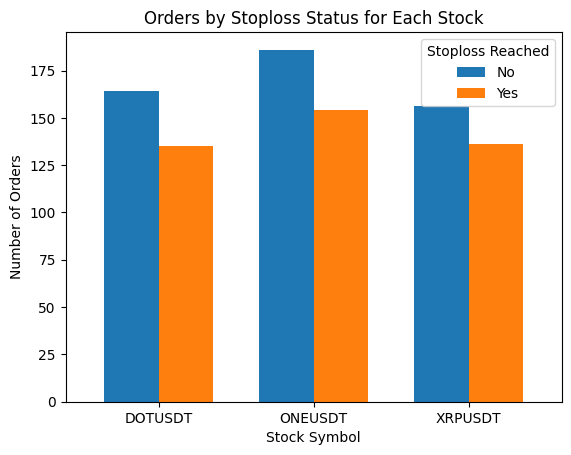

In [87]:
# Count the occurrences of stoploss_reached per stock symbol
grouped = df_aprobados.groupby(['Symbol', 'Stoploss-Reached']).size().unstack(fill_value=0)

# Plot
grouped.plot(kind='bar', width=0.7)
plt.title("Orders by Stoploss Status for Each Stock")
plt.xlabel("Stock Symbol")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.legend(title='Stoploss Reached', labels=['No', 'Yes'])

plt.show()

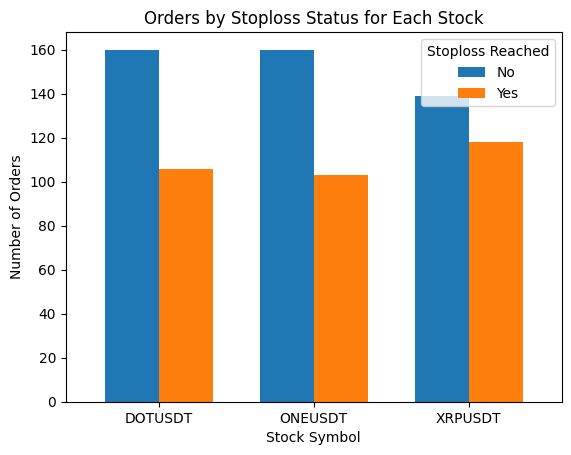

In [88]:
df_desaprobados
grouped = df_desaprobados.groupby(['Symbol', 'Stoploss-Reached']).size().unstack(fill_value=0)

# Plot
grouped.plot(kind='bar', width=0.7)
plt.title("Orders by Stoploss Status for Each Stock")
plt.xlabel("Stock Symbol")
plt.ylabel("Number of Orders")
plt.xticks(rotation=0)
plt.legend(title='Stoploss Reached', labels=['No', 'Yes'])

plt.show()